## Project Setup and Data Sourcing

### Libraries and Environment Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wbgapi as wb
import seaborn as sns
import missingno as msno
import random 
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from imblearn.over_sampling import SMOTE, SMOTENC
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay, partial_dependence
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, ClassifierMixin

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

C:\Users\serej\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\serej\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\serej\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

### Data Loading and Initial Cleaning

#### World Bank Indicators

In [ ]:
# Extracting data from the world bank API

# Define the indicators dictionary
indicators = [
    'NY.GDP.PCAP.KD.ZG', # GDP per capita growth rates
    'SE.TER.CUAT.ST.ZS', # Educational attainment, at least completed short-cycle tertiary, population 25+, total (%)
    'NE.GDI.FTOT.ZS', # Gross fixed capital formation (% of GDP)
    'SP.POP.TOTL',  # Population
    'GB.XPD.RSDV.GD.ZS', # Research and development expenditure (% of GDP)
    'SH.XPD.CHEX.PC.CD', # Current health expenditure per capita (current US$)
    'FP.CPI.TOTL',    # Consumer price index (2010 = 100)
    'FR.INR.RINR',  # Real interest rate (%)
    'SI.POV.GINI',  # Gini Index (World Bank estimate)
    'TG.VAL.TOTL.GD.ZS'  # Merchandise trade (% of GDP)
]

# List of ISO-3 country codes
countries = [
'ALB','AUS','AUT','BEL','BIH','BGR','CAN','HRV','CYP','CZE','DNK','EST','FIN',
'FRA','DEU','GRC','HUN','ISL','IRL','ITA','JPN','LVA','LTU','LUX','MLT','MNE',
'NLD','MKD','NOR','POL','PRT','ROU','SVK','SVN','KOR','ESP','SWE','CHE','TUR',
'GBR','USA','UKR'
]


# Fetch data for all available years for these countries
world_df = wb.data.DataFrame(indicators, economy=countries, labels=True)
      
# Reset index to get country and date into columns
world_df = world_df.reset_index()
 

In [8]:
# Formatting extracted data from the WB
world_df = pd.read_csv("worldbank_selected_indicators_data.csv")

world_df= world_df.drop(['series','economy'], axis=1)

world_df = world_df.melt(id_vars=['Country', 'Series'],
                  var_name='Year',
                  value_name='Value')

# Use pivot_table to reshape the DataFrame
world_df = world_df.pivot_table(
    index=['Country', 'Year'],   
    columns='Series',            
    values='Value'            
).reset_index()   

world_df['Year'] = world_df['Year'].str.replace('YR', '').astype(int)

world_df

Series,Country,Year,Consumer price index (2010 = 100),Current health expenditure per capita (current US$),"Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)",GDP per capita growth (annual %),Gini index,Gross fixed capital formation (% of GDP),Merchandise trade (% of GDP),"Population, total",Real interest rate (%),Research and development expenditure (% of GDP)
0,Albania,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1608800.0,NaN,NaN
1,Albania,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1659800.0,NaN,NaN
2,Albania,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1711319.0,NaN,NaN
3,Albania,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1762621.0,NaN,NaN
4,Albania,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1814135.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2723,United States,2020,118.690502,11672.770508,48.090000,-3.106490,39.7,21.587737,17.944405,331526933.0,2.186282,3.42467
2724,United States,2021,124.266414,11999.090820,47.914421,5.888314,39.7,21.281794,19.803134,332048977.0,-1.258522,3.48313
2725,United States,2022,134.211206,12434.433594,48.119999,2.136362,41.3,21.374360,20.905642,333271411.0,NaN,3.58623
2726,United States,2023,139.735794,NaN,49.142361,2.382669,NaN,21.390622,18.733583,334914895.0,NaN,NaN


In [ ]:
world_df.to_csv("wb_indicators_cleaned.csv", index=False)

#### Military Spending (SIPRI)

In [9]:
# Formatting the data previously extracted from SIPRI
military_spending = pd.read_csv("C:\\Users\\tukhy\\Desktop\\Diploma\\Data\\SIPRI-Milex-data-1949-2024", na_values=['...']) # in "" insert your path to the military_spending file
 
military_spending = pd.concat([military_spending, turkiye.iloc[0].to_frame().T], ignore_index=True)

to_replace = {'Korea, South': 'Korea, Rep.',
    'United States of America': 'United States',
     'Slovakia': 'Slovak Republic',
    'Türkiye': 'Turkiye'}

military_spending['Country'] = military_spending['Country'].replace(to_replace)

military_spending = military_spending.melt(id_vars=['Country'],
                  var_name='Year',
                  value_name='Military_spending')
military_spending['Year'] = military_spending['Year'].astype(int)

military_spending

C:\Users\tukhy\AppData\Local\Temp\ipykernel_68852\2560423982.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  turkiye['Country'].replace({'Türkiye': 'Turkiye'}, inplace = True)


,Country,Year,Military_spending
0,Canada,1949,NaN
1,United States,1949,175907.1
2,Australia,1949,NaN
3,Japan,1949,NaN
4,"Korea, Rep.",1949,NaN
...,...,...,...
3187,Spain,2024,23926.4
3188,Sweden,2024,11718.5
3189,Switzerland,2024,6483.7
3190,United Kingdom,2024,77390.0


In [ ]:
# Save the results
military_spending.to_csv("military_spending1.csv", index=False)

#### Government Ideology

In [8]:
# Formatting the data on countries government ideology created with LLM (Perplexity)
ideology_variable = pd.read_csv("C:\\Users\\tukhy\\Desktop\\Diploma\\Data\\Ideology-variables.csv")

ideology_variable = ideology_variable.drop(['0', 'country'], axis=1)

ideology_variable = ideology_variable.melt(id_vars=['Country'],
                  var_name='Year',
                  value_name='Ideology')
# Creating 4 distinct dataframes for dummy ideology variables, e.g. 1 means ml(moderate left) and 0 means (sth else)
ideologies = ['fl', 'ml', 'mr', 'fr']
ideology_dataframes = {}

for indicator in ideologies:
    df = ideology_variable.copy()
    df['Ideology'] = df['Ideology'].apply(lambda x: '1' if x == indicator else '0')
    ideology_dataframes[indicator] = df

farright = ideology_dataframes['fr']
farleft = ideology_dataframes['fl']
moderateright = ideology_dataframes['mr']
moderateleft = ideology_dataframes['ml']

farright.rename(columns={'Ideology': 'Farright'}, inplace=True)
farleft.rename(columns={'Ideology': 'Farleft'}, inplace=True)
moderateright.rename(columns={'Ideology': 'Moderateright'}, inplace=True)
moderateleft.rename(columns={'Ideology': 'Moderateleft'}, inplace=True)

farright['Year'] = farright['Year'].astype(int)
farleft['Year'] = farleft['Year'].astype(int)
moderateright['Year'] = moderateright['Year'].astype(int)
moderateleft['Year'] = moderateleft['Year'].astype(int)

farright.head(20)

,Country,Year,Farright
0,Albania,1949,0
1,Australia,1949,0
2,Austria,1949,0
3,Belgium,1949,0
4,Bosnia and Herzegovina,1949,0
5,Bulgaria,1949,0
6,Canada,1949,0
7,Croatia,1949,0
8,Cyprus,1949,0
9,Czechia,1949,0


In [ ]:
# Save the results
farright.to_csv("farright.csv", index=False)
farleft.to_csv("farleft.csv", index=False)
moderateright.to_csv("moderateright.csv", index=False)
moderateleft.to_csv("moderateleft.csv", index=False)

#### Labor Force & Unemployment (ILOSTAT)

In [6]:
# Formatting the data on labour force extracted previously from ILOSTAT

pd.set_option('display.max_colwidth', None)
labour_force = pd.read_csv("C:\\Users\\tukhy\\Desktop\\Diploma\\Data\\labour_force.csv")

# Define the replacements using a dictionary
country_replacements = {
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Republic of Korea': 'Korea, Rep.',
    'United States of America': 'United States',
    'Slovakia': 'Slovak Republic'
}

columns_to_drop = [
    'source.label',
    'obs_status.label',
    'note_classif.label',
    'note_indicator.label',
    'note_source.label',
    'classif1.label',
    'sex.label',
    'indicator.label'
]

labour_force.rename(columns = {'ref_area.label' : 'Country', 'time' : 'Year', 'obs_value':'Labour force participation rate by sex and age (%)'}, inplace = True)

adjustment_labour = pd.read_csv("C:\\Users\\tukhy\\Downloads\\EAP_DWAP_SEX_AGE_RT_A-filtered-2025-05-23.csv")
adjustment_labour.rename(columns = {'ref_area.label' : 'Country', 'time' : 'Year', 'obs_value':'Labour force participation rate by sex and age (%)'}, inplace = True)
adjustment_labour = adjustment_labour[~adjustment_labour['Country'].isin(['Republic of Korea', 'Japan'])]
adjustment_labour['Country'].replace({'Türkiye': 'Turkiye'}, inplace = True)
adjustment_labour.drop(columns_to_drop, axis=1, inplace = True)

countries_to_drop = [
    "Andorra", "Belarus", "Bermuda", "Faroe Islands", "Guernsey", "Gibraltar",
    "Greece", "Greenland", "Isle of Man", "Jersey", "Republic of Moldova",
    "Kosovo", "Liechtenstein", "Monaco", "Russian Federation", "San Marino", "Serbia"
]

labour_force = labour_force[~labour_force['Country'].isin(countries_to_drop)]

labour_force.drop(columns_to_drop, axis=1, inplace = True)

labour_force = pd.concat([labour_force, adjustment_labour.iloc[0:256]], ignore_index=True)

labour_force['Country'] = labour_force['Country'].replace(country_replacements)

labour_force.loc[labour_force['Country'] == 'Ukraine', 'Year']

labour_force  = labour_force[~(labour_force['Year'] == 1948)]

labour_force 

C:\Users\tukhy\AppData\Local\Temp\ipykernel_68852\4211243273.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adjustment_labour['Country'].replace({'Türkiye': 'Turkiye'}, inplace = True)


,Country,Year,Labour force participation rate by sex and age (%)
0,Albania,2023,63.882
1,Albania,2022,62.161
2,Albania,2021,59.684
3,Albania,2020,59.367
4,Albania,2019,60.306
...,...,...,...
1656,Turkiye,1975,66.810
1657,Turkiye,1970,67.800
1658,Turkiye,1965,74.400
1659,Turkiye,1960,79.700


In [7]:
# Formatting the data on unemployment extracted previously from ILOSTAT
unemployment = pd.read_csv("C:\\Users\\tukhy\\Desktop\\Diploma\\Data\\unemp.csv")

# Define the replacements using a dictionary
country_replacements = {
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Republic of Korea': 'Korea, Rep.',
    'United States of America': 'United States',
     'Slovakia': 'Slovak Republic'
}
columns_to_drop = [
    'source.label',
    'obs_status.label',
    'note_classif.label',
    'note_indicator.label',
    'note_source.label',
    'classif1.label',
    'sex.label',
    'indicator.label'
]
unemployment.rename(columns = {'ref_area.label' : 'Country', 'time' : 'Year', 'obs_value':'Unemployment rate by sex and age (%)'}, inplace = True)

adjustment_unemp = pd.read_csv("C:\\Users\\tukhy\\Downloads\\unemp_new.csv")
adjustment_unemp.rename(columns = {'ref_area.label' : 'Country', 'time' : 'Year', 'obs_value':'Unemployment rate by sex and age (%)'}, inplace = True)
adjustment_unemp['Country'].replace({'Türkiye': 'Turkiye', 'Republic of Korea': 'Korea, Rep.' }, inplace = True)
adjustment_unemp.drop(columns_to_drop, axis=1, inplace = True)


countries_to_drop = [
    "Andorra", "Belarus", "Bermuda", "Faroe Islands", "Guernsey", "Gibraltar",
    "Greece", "Greenland", "Isle of Man", "Jersey", "Republic of Moldova",
    "Kosovo", "Liechtenstein", "Monaco", "Russian Federation", "San Marino", "Serbia", "European Union"
]

unemployment = unemployment[~unemployment['Country'].isin(countries_to_drop)]


 
unemployment.drop(columns_to_drop, axis=1, inplace = True)

unemployment = pd.concat([unemployment, adjustment_unemp.iloc[0:256]], ignore_index=True)
 
unemployment['Country'] = unemployment['Country'].replace(country_replacements) 

unemployment  = unemployment[~(unemployment['Year'] == 1948)]

unemployment

C:\Users\tukhy\AppData\Local\Temp\ipykernel_68852\2573489442.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adjustment_unemp['Country'].replace({'Türkiye': 'Turkiye', 'Republic of Korea': 'Korea, Rep.' }, inplace = True)


,Country,Year,Unemployment rate by sex and age (%)
0,Albania,2023,10.669
1,Albania,2022,10.785
2,Albania,2021,11.474
3,Albania,2020,11.639
4,Albania,2019,11.466
...,...,...,...
1576,Turkiye,2004,10.838
1577,Turkiye,2003,10.542
1578,Turkiye,2002,10.358
1579,Turkiye,2001,8.381


In [ ]:
# Save the results
labour_force.to_csv("lab_force.csv", index=False)
unemployment.to_csv("unemployment.csv", index=False)

### Data Integration and Final Structure

In [ ]:
# Read all saved results (optional)
world_df = pd.read_csv("wb_indicators_cleaned.csv")
unemployment = pd.read_csv("unemployment.csv")
labour_force = pd.read_csv("lab_force.csv")
military_spending = pd.read_csv("military_spending1.csv")
farright = pd.read_csv("farright.csv")
farleft = pd.read_csv("farleft.csv")
moderateright = pd.read_csv("moderateright.csv")
moderateleft = pd.read_csv("moderateleft.csv")

In [10]:

# Perform the outer merge 1: Unemployment
wb_df = pd.merge(
    world_df,
    unemployment[['Country', 'Year', 'Unemployment rate by sex and age (%)']], # Select only necessary columns from unemployment
    on=['Country', 'Year'],  # Columns to join on
    how='outer'              # Type of merge: keep all rows from both
)
# Perform the outer merge 2:Labour
wb_df = pd.merge(
    wb_df,
    labour_force[['Country', 'Year', 'Labour force participation rate by sex and age (%)']], # Select only necessary columns from unemployment
    on=['Country', 'Year'],  # Columns to join on
    how='outer'              # Type of merge: keep all rows from both
)
# Perform the outer merge 3: Military spending
wb_df = pd.merge(
    wb_df,
    military_spending[['Country', 'Year', 'Military_spending']], # Select only necessary columns from unemployment
    on=['Country', 'Year'],  # Columns to join on
    how='outer'              # Type of merge: keep all rows from both
)
# Perform the outer merge 4: Farright
wb_df = pd.merge(
    wb_df,
    farright[['Country', 'Year', 'Farright']], # Select only necessary columns from unemployment
    on=['Country', 'Year'],  # Columns to join on
    how='outer'              # Type of merge: keep all rows from both
)
# Perform the outer merge 5: Farleft
wb_df = pd.merge(
    wb_df,
    farleft[['Country', 'Year', 'Farleft']], # Select only necessary columns from unemployment
    on=['Country', 'Year'],  # Columns to join on
    how='outer'              # Type of merge: keep all rows from both
)
# Perform the outer merge 6: Moderateright
wb_df = pd.merge(
    wb_df,
   moderateright[['Country', 'Year', 'Moderateright']], # Select only necessary columns from unemployment
    on=['Country', 'Year'],  # Columns to join on
    how='outer'              # Type of merge: keep all rows from both
)
# Perform the outer merge 7: Moderateleft
wb_df = pd.merge(
    wb_df,
    moderateleft[['Country', 'Year', 'Moderateleft']], # Select only necessary columns from unemployment
    on=['Country', 'Year'],  # Columns to join on
    how='outer'              # Type of merge: keep all rows from both
)
# Drop unrelevant variable
wb_df = wb_df.drop('Real interest rate (%)', axis = 1)

# Renaming columns to be more readable and concise 
columns_to_rename_from_wb_df={
                     'Consumer price index (2010 = 100)': 'CPI',
                     'Current health expenditure per capita (current US$)': 'Health expenditure',
                     'Educational attainment, at least completed short-cycle tertiary, population 25+, total (%) (cumulative)': 'Educational attainment',
                     'GDP per capita growth (annual %)': 'GDP per cap.',
                     'Gross fixed capital formation (% of GDP)': 'Capital formation',
                     'Merchandise trade (% of GDP)': 'Merchandise trade',
                     'Population, total': 'Population',
                     'Research and development expenditure (% of GDP)': 'R&D',
                     'Unemployment rate by sex and age (%)': 'Unemployment',
                     'Labour force participation rate by sex and age (%)': 'Labour force'}

wb_df.rename(columns = columns_to_rename_from_wb_df, inplace = True)

wb_df 
 

,Country,Year,CPI,Health expenditure,Educational attainment,GDP per cap.,Gini index,Capital formation,Merchandise trade,Population,R&D,Unemployment,Labour force,Military_spending,Farright,Farleft,Moderateright,Moderateleft
0,Albania,1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
1,Albania,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,Albania,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
3,Albania,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
4,Albania,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,United States,2020,118.690502,11672.770508,48.090000,-3.106490,39.7,21.587737,17.944405,331526933.0,3.42467,8.055,61.746,916416.6,0,0,1,0
3188,United States,2021,124.266414,11999.090820,47.914421,5.888314,39.7,21.281794,19.803134,332048977.0,3.48313,5.349,61.659,906594.3,0,0,1,0
3189,United States,2022,134.211206,12434.433594,48.119999,2.136362,41.3,21.374360,20.905642,333271411.0,3.58623,3.650,62.236,896121.2,0,0,1,0
3190,United States,2023,139.735794,NaN,49.142361,2.382669,NaN,21.390622,18.733583,334914895.0,NaN,3.638,62.604,916014.7,0,0,1,0


In [11]:
all_countries = wb_df['Country'].unique()

# Find countries that have at least one non-NaN value for 'Educational attainment' before 1992
countries_with_data_pre1992 = wb_df[
    (wb_df['Year'] < 1992) & 
    (wb_df['Educational attainment'].notna())
]['Country'].unique()

# Now find countries that don't have any data before 1992
countries_without_data_pre1992 = set(all_countries) - set(countries_with_data_pre1992)

print(countries_without_data_pre1992)

# Code to see more rows of indicator for specific country
see_the_country_data = wb_df[wb_df['Country']=='Albania'].head(50)


{'Cyprus', 'North Macedonia', 'Romania', 'Bulgaria', 'Finland', 'Belgium', 'Sweden', 'Bosnia and Herzegovina', 'Montenegro', 'Malta', 'Australia', 'Albania', 'Ireland', 'Latvia', 'Luxembourg', 'Iceland', 'Netherlands', 'Germany', 'Slovenia', 'Austria', 'France', 'Switzerland', 'Czechia'}


## Exploratory Data Analysis (EDA) and Preprocessing

### Missing Data Analysis and Imputation

#### Visualizing Missingness Patterns

<Axes: >

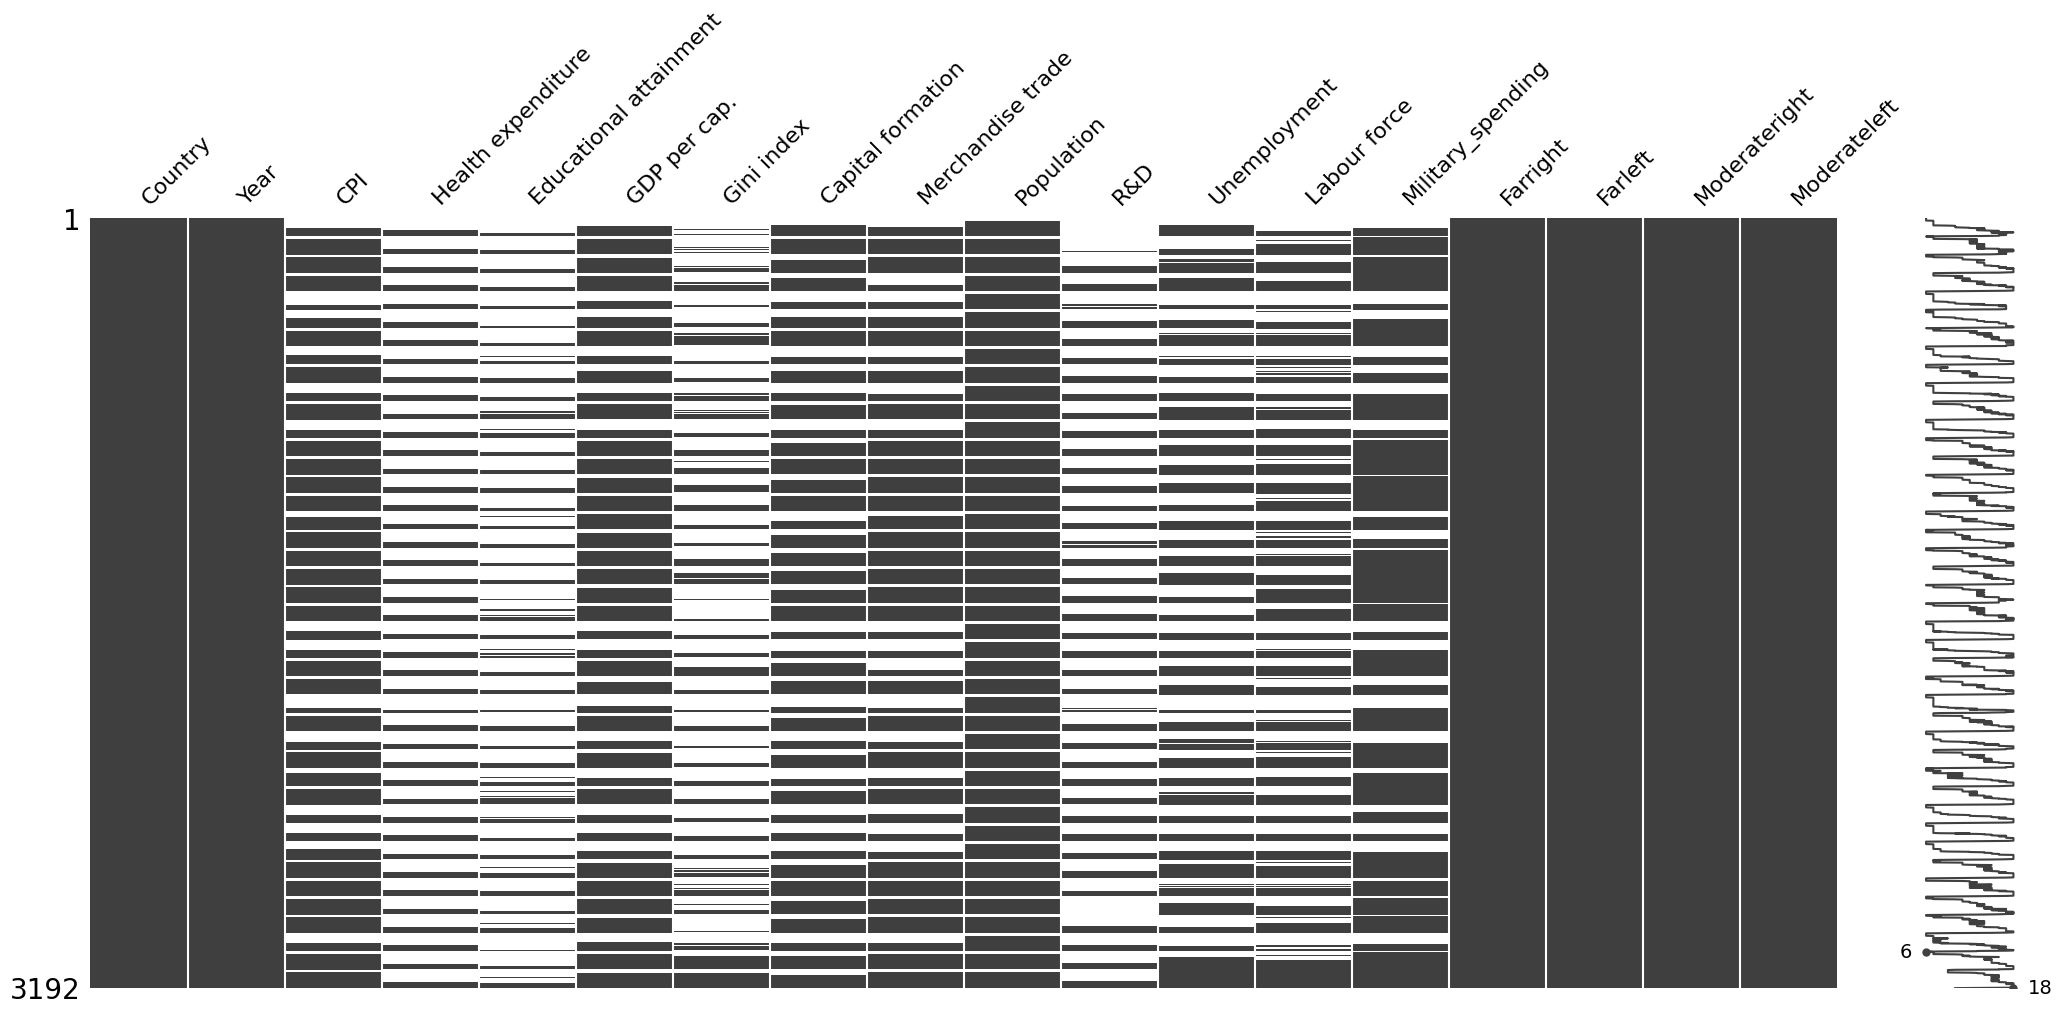

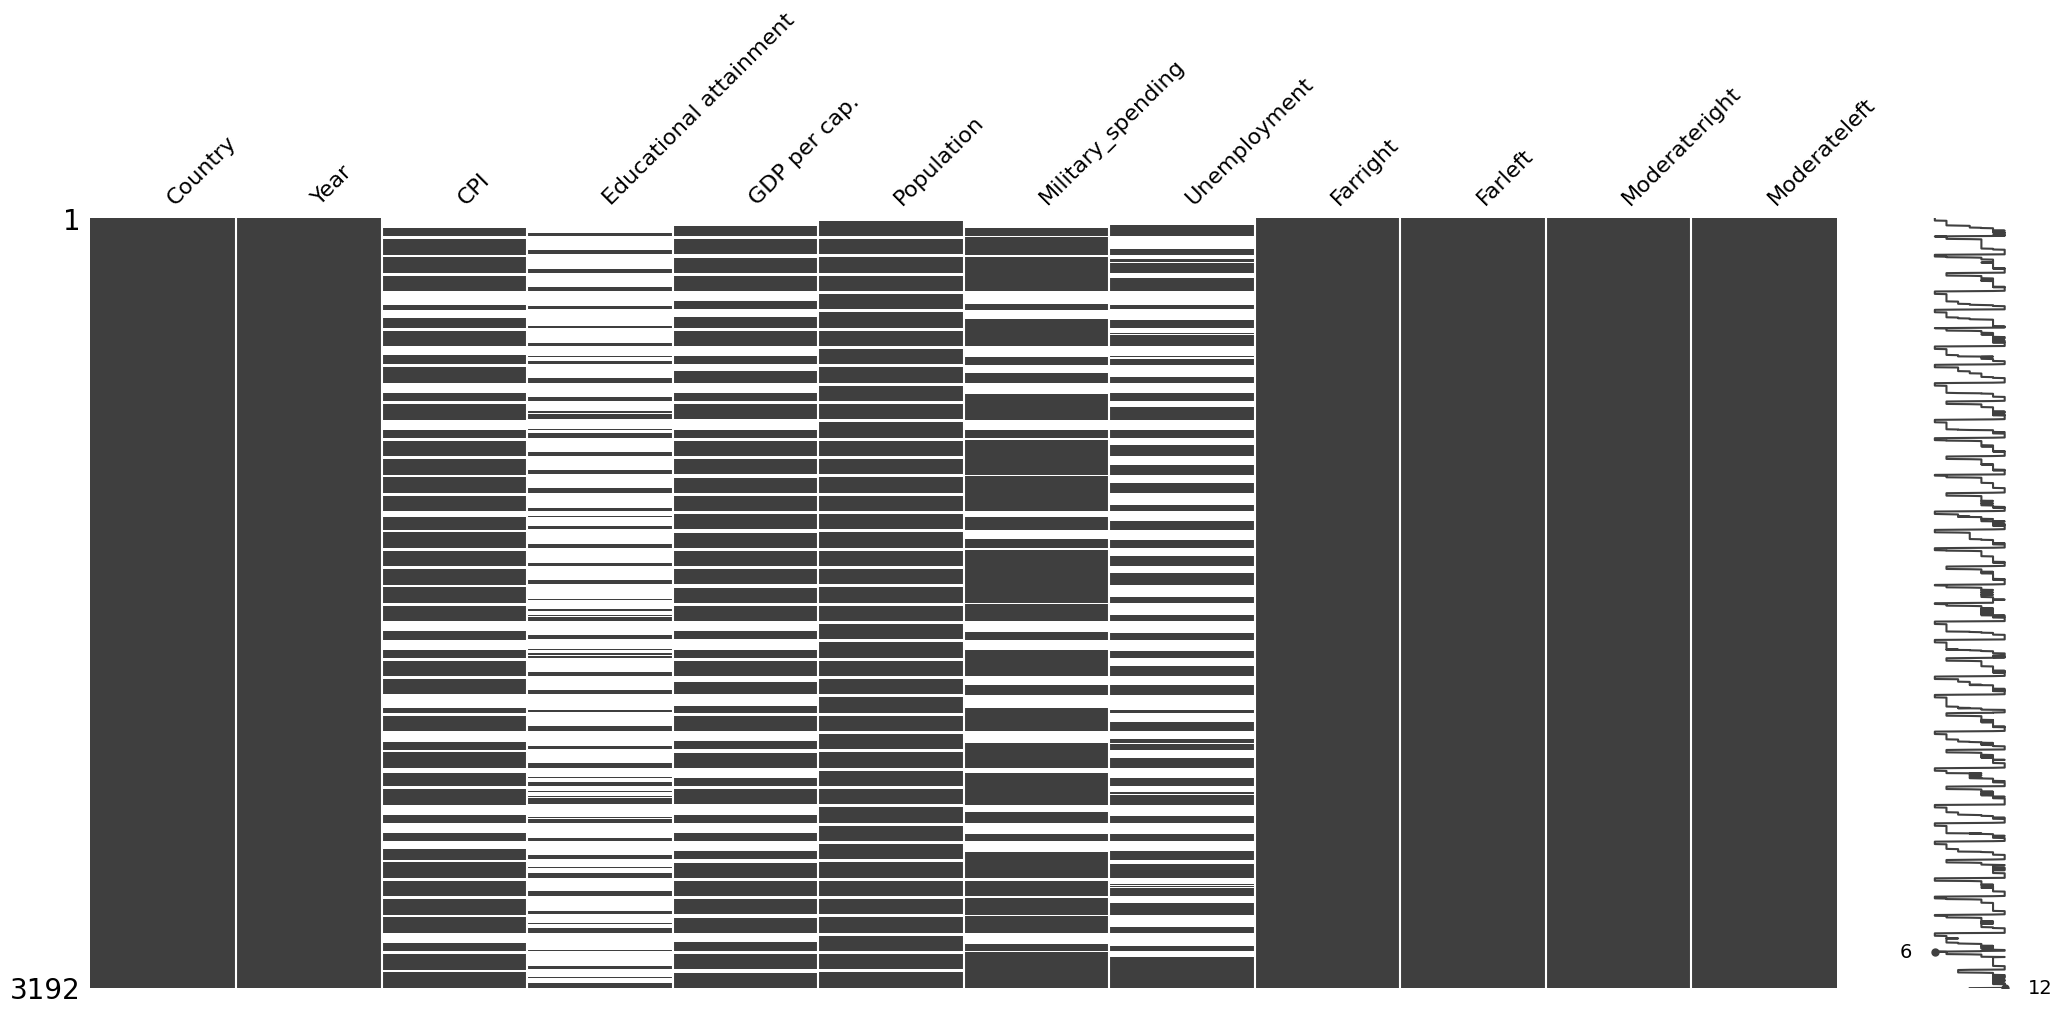

In [12]:
# Model with all variables kept
full_model = wb_df.dropna()

# Analyze missingnes pattern of full model
msno.matrix(wb_df)


# Model with partial set of variables
partial_model = wb_df[['Country',
'Year','CPI',
'Educational attainment',
'GDP per cap.',
'Population',
'Unemployment',
'Farright','Farleft','Moderateright',
'Moderateleft']].dropna()

# Analyze missingnes pattern of partial  model
msno.matrix(wb_df[['Country','Year','CPI',
'Educational attainment',
'GDP per cap.',
'Population',
'Military_spending',
'Unemployment',
'Farright','Farleft','Moderateright',
'Moderateleft']])


In [15]:
columns_to_remove2 = ['Farright',	'Farleft',	'Moderateright',	'Moderateleft']
df_cleaned = wb_df.drop(columns=columns_to_remove2, axis=1)
full_model_long = df_cleaned.melt(id_vars=['Country', 'Year'], var_name='Indicator', value_name='Value')
full_model_long  = full_model_long .sort_values(by=['Country', 'Indicator', 'Year'])

full_model_long

,Country,Year,Indicator,Value
0,Albania,1949,CPI,NaN
1,Albania,1950,CPI,NaN
2,Albania,1951,CPI,NaN
3,Albania,1952,CPI,NaN
4,Albania,1953,CPI,NaN
...,...,...,...,...
31915,United States,2020,Unemployment,8.055
31916,United States,2021,Unemployment,5.349
31917,United States,2022,Unemployment,3.650
31918,United States,2023,Unemployment,3.638


#### Identifying and Analyzing Data Gaps

##### Data gaps per country

In [ ]:
pd.set_option('future.no_silent_downcasting', True)

def has_gap(group):
    mask = group['Value'].isnull()
    filled_forward = group['Value'].ffill().infer_objects(copy=False)
    filled_backward = group['Value'].bfill().infer_objects(copy=False)
    in_between_missing = mask & filled_forward.notnull() & filled_backward.notnull()
    group['Gap'] = in_between_missing
    return group

df_checked = full_model_long.groupby(['Country', 'Indicator']).apply(has_gap)

df_checked = df_checked.reset_index(drop = True)

gaps_found = df_checked[df_checked['Gap']]
summary = gaps_found.groupby(['Country', 'Indicator']).size()
summary_df = gaps_found.groupby(['Country', 'Indicator']).size().reset_index(name='Gap_Count')
summary

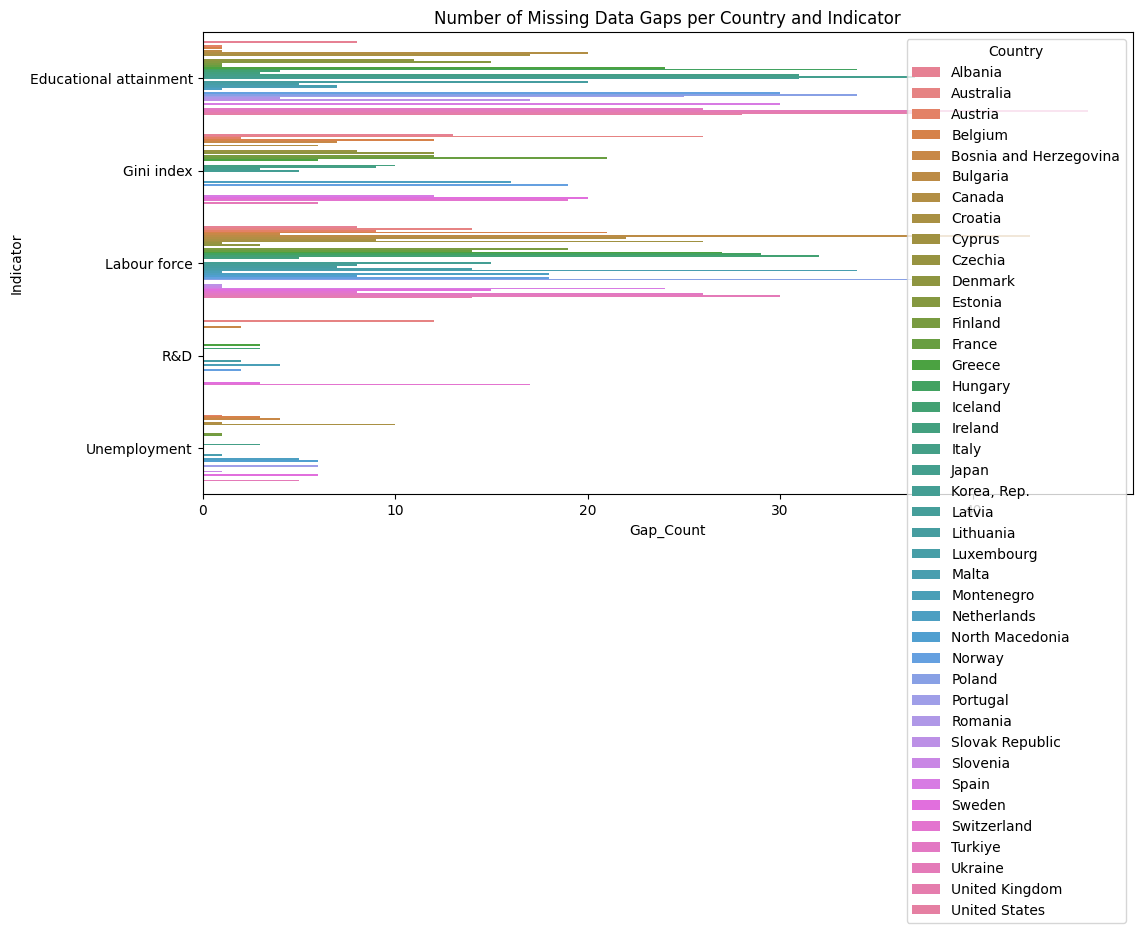

In [233]:
# Visualization of data gaps for indicators
plt.figure(figsize=(12,6))
sns.barplot(
    data=summary_df, 
    x='Gap_Count', 
    y='Indicator', 
    hue='Country'
)
plt.title('Number of Missing Data Gaps per Country and Indicator')
plt.show()

##### Missing pattern for each indicator

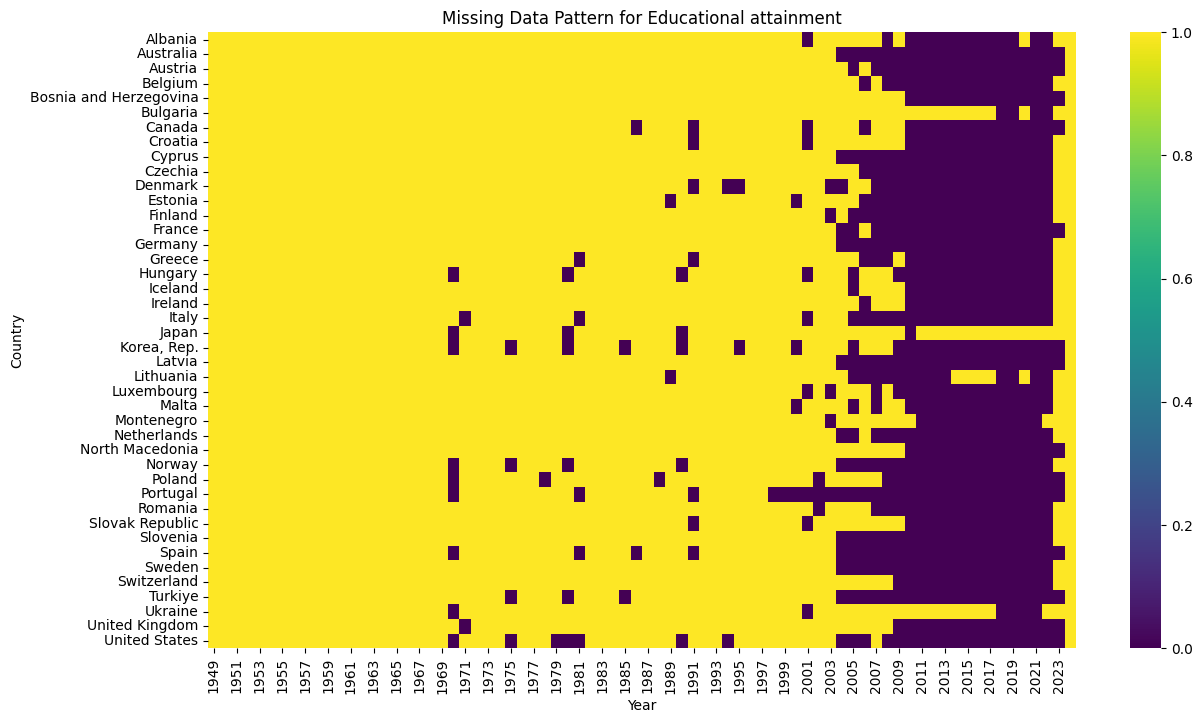

In [168]:
# Visualization of data gaps across countries for Educational attainment
# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'Educational attainment']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for Educational attainment')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

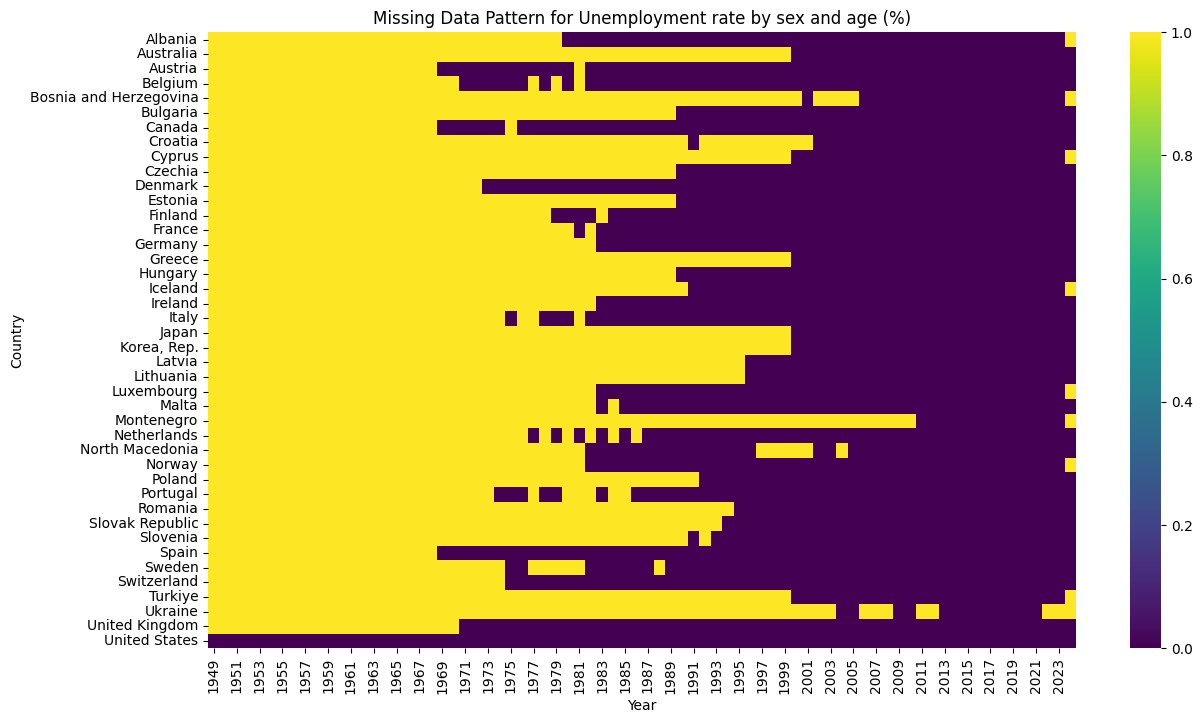

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'Unemployment']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for Unemployment rate by sex and age (%)')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

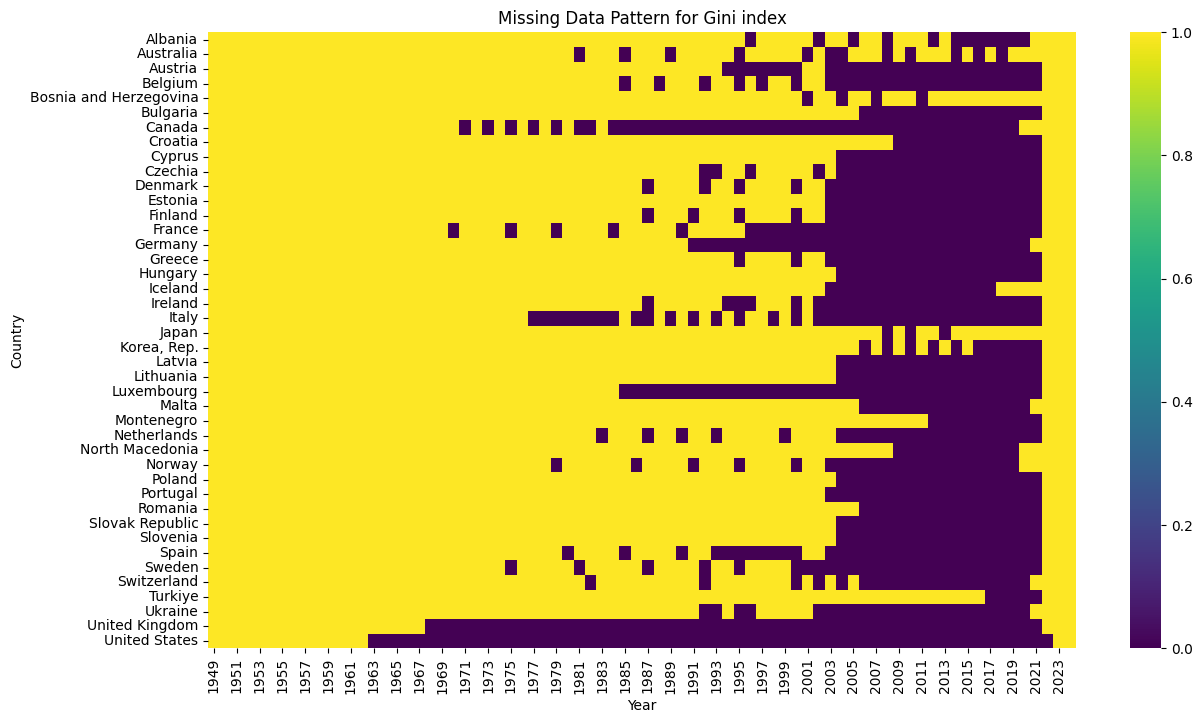

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'Gini index']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for Gini index')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

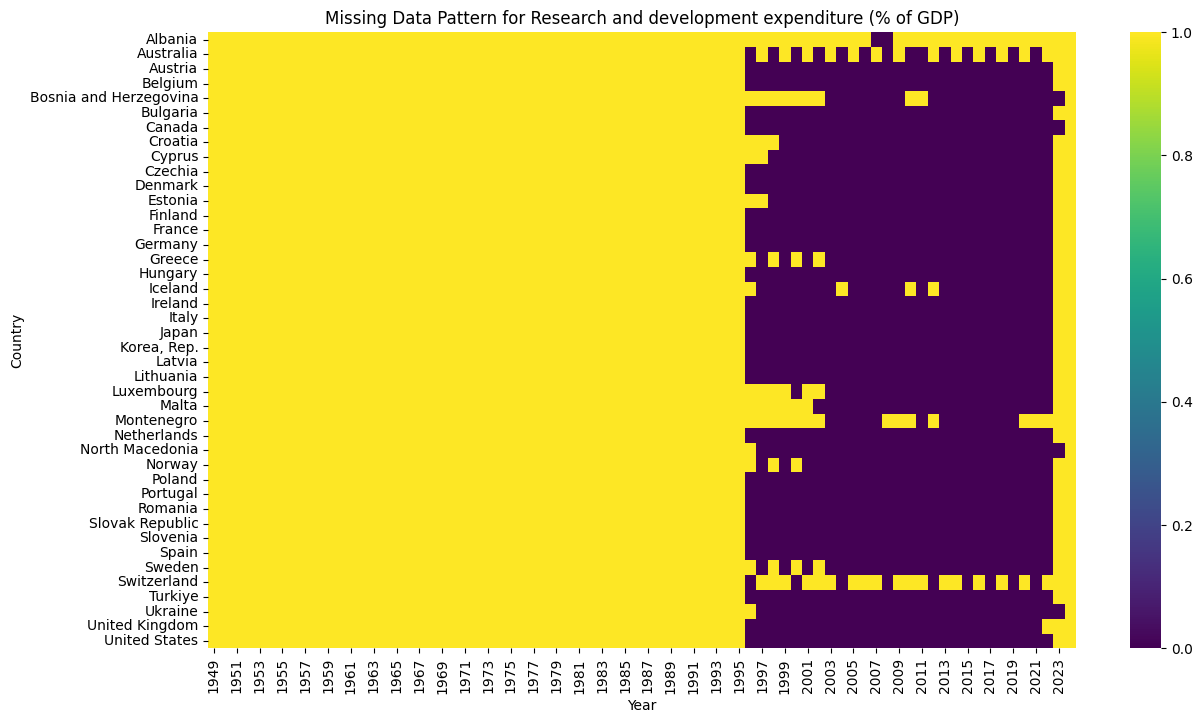

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'R&D']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for Research and development expenditure (% of GDP)')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

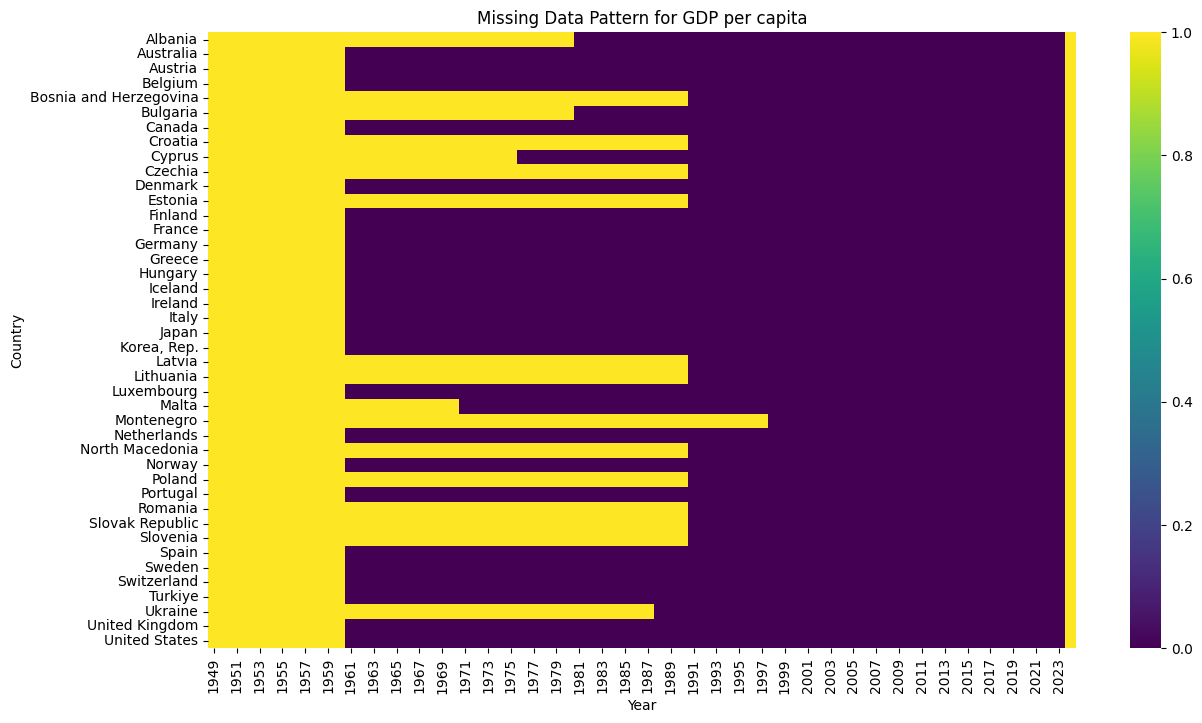

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'GDP per cap.']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for GDP per capita')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

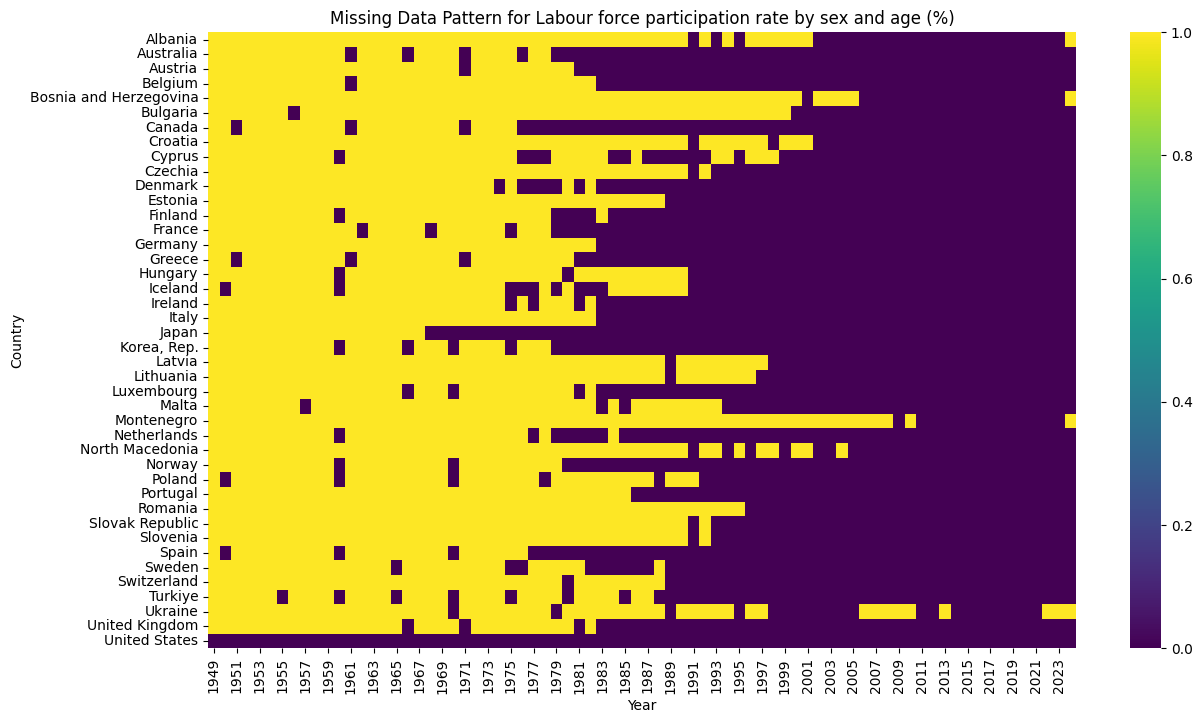

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'Labour force']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for Labour force participation rate by sex and age (%)')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

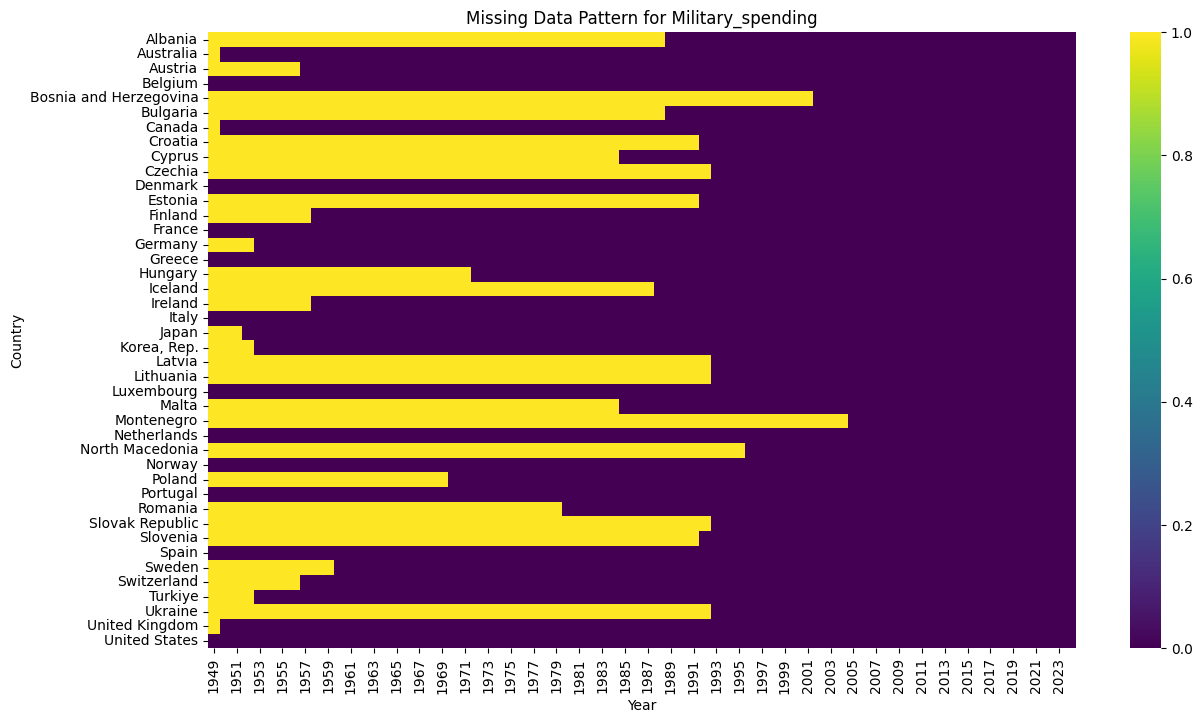

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'Military_spending']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for Military_spending')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

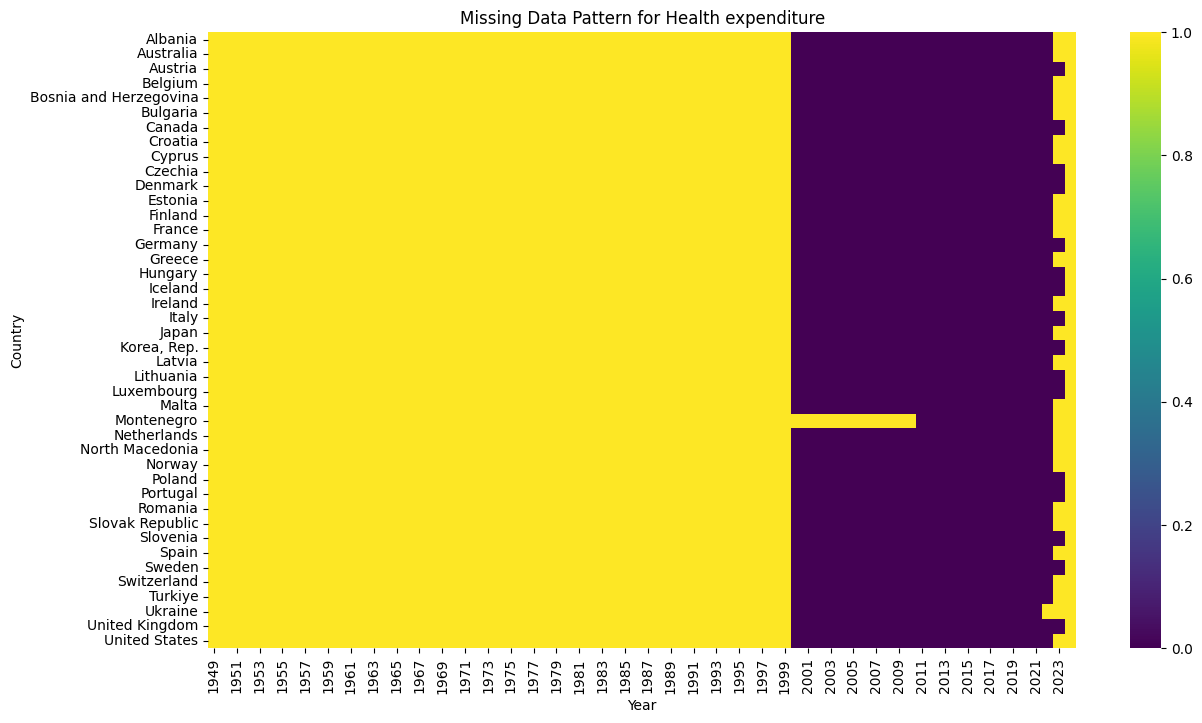

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'Health expenditure']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for Health expenditure')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

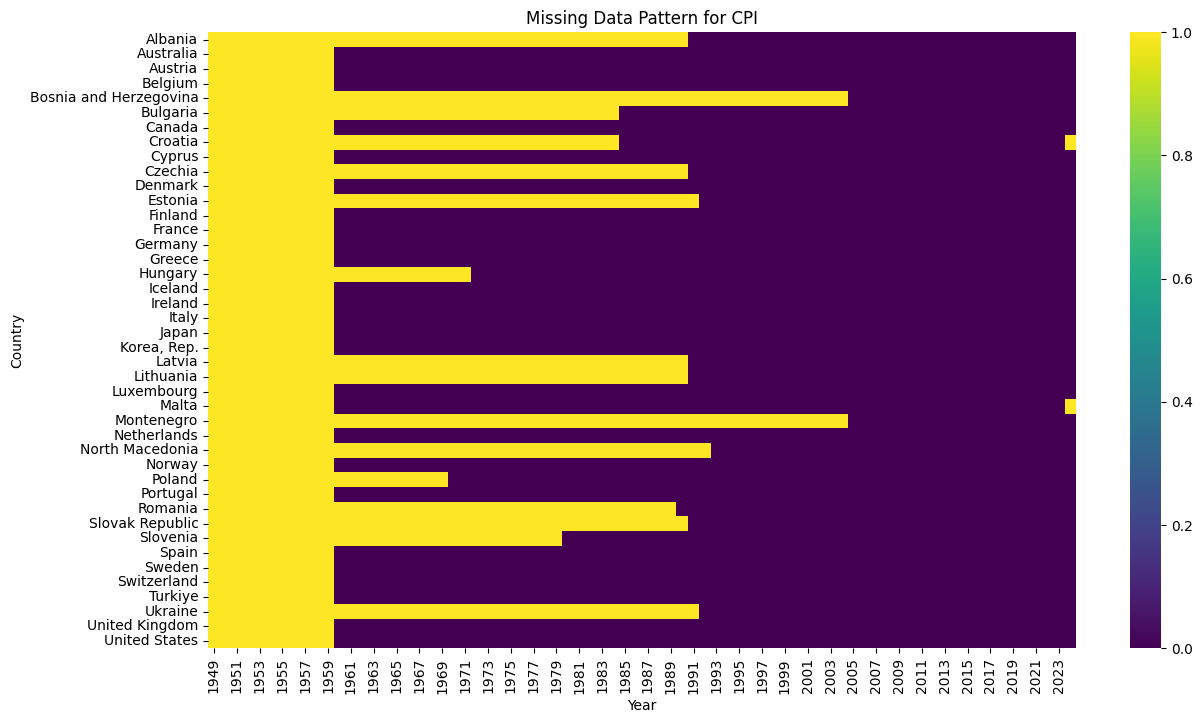

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'CPI']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for CPI')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

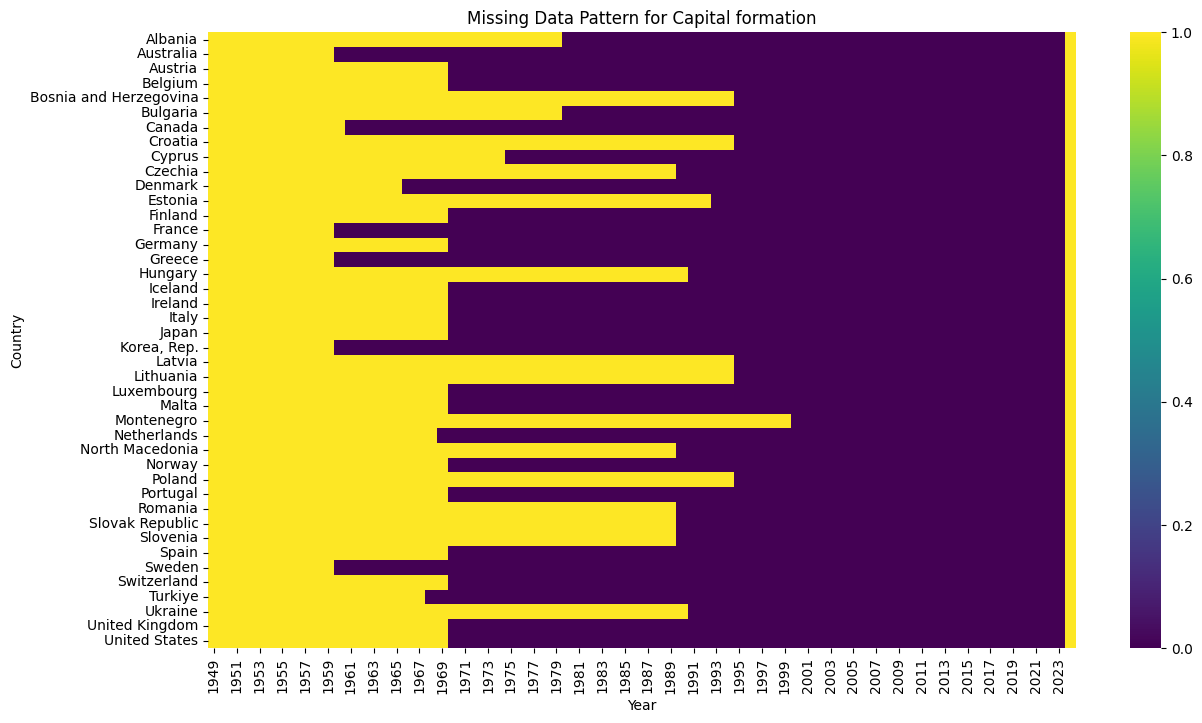

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'Capital formation']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for Capital formation')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

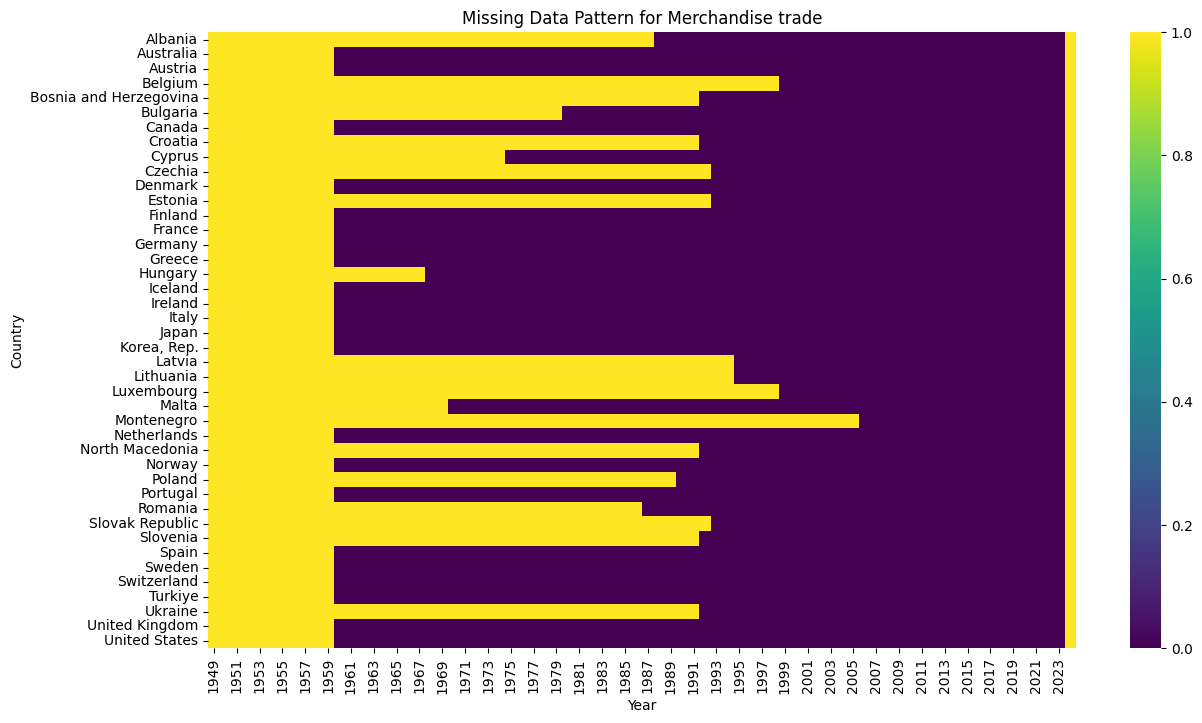

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table where values are missingness indicators (1=missing, 0=present)
heatmap_data = full_model_long.copy()
heatmap_data['is_missing'] = heatmap_data['Value'].isnull().astype(int)

# Example for one indicator at a time (e.g. 'GDP')
gdp_missing = heatmap_data[heatmap_data['Indicator'] == 'Merchandise trade']

pivot = gdp_missing.pivot_table(
    index='Country', 
    columns='Year', 
    values='is_missing', 
    aggfunc='first'
)

# Plot heatmap
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="viridis", cbar=True)
plt.title('Missing Data Pattern for Merchandise trade')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

#### MICE Imputation and Manual Correction

In [17]:
full_model_long = pd.read_csv("full_model_long.csv")
df_checked = pd.read_csv("df_checked.csv")

# Delete all rows for countries in years that are not in the 'Gap'
full_model_long = df_checked[(df_checked['Gap'] == True) | (df_checked['Value'].notna())].reset_index(drop=True)
full_model_long = full_model_long.drop(columns=['Gap'])

# Copy your base dataframe to work with (if you want to preserve the original)
df_to_impute_educ = full_model_long.copy()

# Get list of valid years for each country from df_to_impute_educ
valid_years_per_country_educ = (
    df_to_impute_educ[df_to_impute_educ['Indicator'] == 'Educational attainment']
    .groupby('Country')['Year']
    .unique()
    .to_dict()
)

random.seed(52)

# Prepare a list to collect results
imputed_dfs_educ = []

# Impute within each Country
for country, group in df_to_impute_educ.groupby('Country'):
    
    # Filter to only valid years for this country
    valid_years = valid_years_per_country_educ.get(country, [])
    group = group[group['Year'].isin(valid_years)]
    
    # Pivot to wide format: Years as index, Indicators as columns
    pivoted = group.pivot(index='Year', columns='Indicator', values='Value')
    
    # Initialize Iterative Imputer (MICE)
    imputer = IterativeImputer(random_state=0, max_iter=100)
    
    # Fit and transform
    imputed_values = imputer.fit_transform(pivoted)
    
    # Build DataFrame back from imputed values
    imputed_df = pd.DataFrame(imputed_values, columns=pivoted.columns, index=pivoted.index)
    
  # Extract only the imputed values for Educational attainment where it was missing
    original_values = pivoted['Educational attainment']
    imputed_educ = imputed_df['Educational attainment']
    
    updated_educ = pd.DataFrame({
        'Country': country,
        'Year': pivoted.index,
        'Indicator': 'Educational attainment',
        'Value': np.where(original_values.isnull(), imputed_educ, original_values)
    })
    
    imputed_dfs_educ.append(updated_educ)

# Concatenate all imputed Educational attainment values
imputed_educ_df = pd.concat(imputed_dfs_educ, ignore_index=True)

# Remove existing rows for Educational attainment where value was missing
mask = (df_to_impute_educ['Indicator'] == 'Educational attainment') & (
   df_to_impute_educ.set_index(['Country', 'Year']).index.isin(
        imputed_educ_df.set_index(['Country', 'Year']).index
    )
)
df_to_impute_educ = df_to_impute_educ[~mask]

# Add imputed Educational attainment values back
df_to_impute_educ = pd.concat([df_to_impute_educ, imputed_educ_df], ignore_index=True)

# Optional: sort for clarity
df_to_impute_educ= df_to_impute_educ.sort_values(by=['Country', 'Indicator', 'Year']).reset_index(drop=True)

In [18]:
full_model_long = pd.read_csv("full_model_long.csv")
df_checked = pd.read_csv("df_checked.csv")

# Delete all rows for countries in years that are not in the 'Gap'
full_model_long = df_checked[(df_checked['Gap'] == True) | (df_checked['Value'].notna())].reset_index(drop=True)
full_model_long = full_model_long.drop(columns=['Gap'])

# Copy your base dataframe to work with
df_to_impute_gini = full_model_long.copy()

# STEP 1: Get valid years per country for **Gini index**
valid_years_per_country_gini = (
    df_to_impute_gini[df_to_impute_gini['Indicator'] == 'Gini index']
    .groupby('Country')['Year']
    .unique()
    .to_dict()
)

random.seed(52)

# STEP 2: Impute missing Gini index values per country
imputed_dfs_gini = []

for country, group in df_to_impute_gini.groupby('Country'):
    
    valid_years = valid_years_per_country_gini.get(country, [])
    group = group[group['Year'].isin(valid_years)]
    
    # Pivot to wide format (Years as index, Indicators as columns)
    pivoted = group.pivot(index='Year', columns='Indicator', values='Value')
    
    if 'Gini index' not in pivoted.columns:
        continue  # **NEW: skip if no Gini index column after pivot**

    # Initialize and run Iterative Imputer (MICE)
    imputer = IterativeImputer(random_state=0, max_iter=100)
    imputed_values = imputer.fit_transform(pivoted)
    
    # Build DataFrame from imputed values
    imputed_df = pd.DataFrame(imputed_values, columns=pivoted.columns, index=pivoted.index)
    
    # Get the original Gini index values (before imputation)
    original_values = pivoted['Gini index'].copy()

    # Get imputed Gini index values (same shape as pivoted)
    imputed_gini = imputed_df['Gini index']

    # Only replace where original values were NaN
    # Create a copy to store final values
    final_values = original_values.copy()

    # Update only missing positions with imputed values
    final_values.loc[original_values.isnull()] = imputed_gini.loc[original_values.isnull()]

    # Build dataframe with updated Gini index values
    updated_gini = pd.DataFrame({
        'Country': country,
        'Year': pivoted.index,
        'Indicator': 'Gini index',
        'Value': final_values
    })

    imputed_dfs_gini.append(updated_gini)

# STEP 3: Concatenate all imputed Gini index values
imputed_gini_df = pd.concat(imputed_dfs_gini, ignore_index=True)

# STEP 4: Remove existing Gini index rows for those (Country, Year) pairs
mask = (df_to_impute_gini['Indicator'] == 'Gini index') & (
    df_to_impute_gini.set_index(['Country', 'Year']).index.isin(
        imputed_gini_df.set_index(['Country', 'Year']).index
    )
)
df_to_impute_gini = df_to_impute_gini[~mask]

# STEP 5: Add new imputed Gini index values back into dataframe
df_to_impute_gini = pd.concat([df_to_impute_gini, imputed_gini_df], ignore_index=True)

# STEP 6: Optional — sort for clarity
df_to_impute_gini = df_to_impute_gini.sort_values(by=['Country', 'Indicator', 'Year']).reset_index(drop=True)

# df_to_impute_gini is now your clean, imputed Gini index dataframe


In [19]:
full_model_long = pd.read_csv("full_model_long.csv")
df_checked = pd.read_csv("df_checked.csv")

# Delete all rows for countries in years that are not in the 'Gap'
full_model_long = df_checked[(df_checked['Gap'] == True) | (df_checked['Value'].notna())].reset_index(drop=True)
full_model_long = full_model_long.drop(columns=['Gap'])

# Copy your base dataframe to work with
df_to_impute_lab = full_model_long.copy()

# STEP 1: Get valid years per country for **Labour force**
valid_years_per_country_lab = (
    df_to_impute_lab[df_to_impute_lab['Indicator'] == 'Labour force']
    .groupby('Country')['Year']
    .unique()
    .to_dict()
)

random.seed(52)

# STEP 2: Impute missing Gini index values per country
imputed_dfs_lab = []

for country, group in df_to_impute_lab.groupby('Country'):
    
    valid_years = valid_years_per_country_lab.get(country, [])
    group = group[group['Year'].isin(valid_years)]
    
    # Pivot to wide format (Years as index, Indicators as columns)
    pivoted = group.pivot(index='Year', columns='Indicator', values='Value')
    
    if 'Labour force' not in pivoted.columns:
        continue  # **NEW: skip if no Gini index column after pivot**

    # Initialize and run Iterative Imputer (MICE)
    imputer = IterativeImputer(random_state=0, max_iter=100)
    imputed_values = imputer.fit_transform(pivoted)
    
    # Build DataFrame from imputed values
    imputed_df = pd.DataFrame(imputed_values, columns=pivoted.columns, index=pivoted.index)
    
    # **CORRECTED PART**
    # Get the original Gini index values (before imputation)
    original_values = pivoted['Labour force'].copy()

    # Get imputed Gini index values (same shape as pivoted)
    imputed_lab = imputed_df['Labour force']

    # Only replace where original values were NaN
    # Create a copy to store final values
    final_values = original_values.copy()

    # Update only missing positions with imputed values
    final_values.loc[original_values.isnull()] = imputed_lab.loc[original_values.isnull()]

    # Build dataframe with updated Gini index values
    updated_lab = pd.DataFrame({
        'Country': country,
        'Year': pivoted.index,
        'Indicator': 'Labour force',
        'Value': final_values
    })

    imputed_dfs_lab.append(updated_lab)

# STEP 3: Concatenate all imputed Gini index values
imputed_lab_df = pd.concat(imputed_dfs_lab, ignore_index=True)

# STEP 4: Remove existing Gini index rows for those (Country, Year) pairs
mask = (df_to_impute_lab['Indicator'] == 'Labour force') & (
    df_to_impute_lab.set_index(['Country', 'Year']).index.isin(
        imputed_lab_df.set_index(['Country', 'Year']).index
    )
)
df_to_impute_lab = df_to_impute_lab[~mask]

# STEP 5: Add new imputed Gini index values back into dataframe
df_to_impute_lab = pd.concat([df_to_impute_lab, imputed_lab_df], ignore_index=True)

# STEP 6: Optional — sort for clarity
df_to_impute_lab = df_to_impute_lab.sort_values(by=['Country', 'Indicator', 'Year']).reset_index(drop=True)

# df_to_impute_gini is now your clean, imputed Gini index dataframe


C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [82]:
full_model_long = pd.read_csv("full_model_long.csv")
df_checked = pd.read_csv("df_checked.csv")

# Delete all rows for countries in years that are not in the 'Gap'
full_model_long = df_checked[(df_checked['Gap'] == True) | (df_checked['Value'].notna())].reset_index(drop=True)
full_model_long = full_model_long.drop(columns=['Gap'])

# Copy your base dataframe to work with 
df_to_impute_unemp = full_model_long.copy()

# STEP 1: Get valid years per country for **Unemployment**
valid_years_per_country_unemp = (
    df_to_impute_unemp[df_to_impute_unemp['Indicator'] == 'Unemployment']
    .groupby('Country')['Year']
    .unique()
    .to_dict()
)

random.seed(52)

# STEP 2: Impute missing Unemployment values per country
imputed_dfs_unemp = []

for country, group in df_to_impute_unemp.groupby('Country'):
    
    valid_years = valid_years_per_country_unemp.get(country, [])
    group = group[group['Year'].isin(valid_years)]
    
    # Pivot to wide format (Years as index, Indicators as columns)
    pivoted = group.pivot(index='Year', columns='Indicator', values='Value')
    
    if 'Unemployment' not in pivoted.columns:
        continue  # **NEW: skip if no Unemployment column after pivot**

    # Initialize and run Iterative Imputer (MICE)
    imputer = IterativeImputer(random_state=0, max_iter=100)
    imputed_values = imputer.fit_transform(pivoted)
    
    # Build DataFrame from imputed values
    imputed_df = pd.DataFrame(imputed_values, columns=pivoted.columns, index=pivoted.index)
    
    # **CORRECTED PART**
    # Get the original Unemployment values (before imputation)
    original_values = pivoted['Unemployment'].copy()

    # Get imputed Unemployment values (same shape as pivoted)
    imputed_unemp = imputed_df['Unemployment']

    # Only replace where original values were NaN
    # Create a copy to store final values
    final_values = original_values.copy()

    # Update only missing positions with imputed values
    final_values.loc[original_values.isnull()] = imputed_unemp.loc[original_values.isnull()]

    # Build dataframe with updated Unemployment values
    updated_unemp = pd.DataFrame({
        'Country': country,
        'Year': pivoted.index,
        'Indicator': 'Unemployment',
        'Value': final_values
    })

    imputed_dfs_unemp.append(updated_unemp)

# STEP 3: Concatenate all imputed Unemployment values
imputed_unemp_df = pd.concat(imputed_dfs_unemp, ignore_index=True)

# STEP 4: Remove existing Unemployment rows for those (Country, Year) pairs
mask = (df_to_impute_unemp['Indicator'] == 'Unemployment') & (
    df_to_impute_unemp.set_index(['Country', 'Year']).index.isin(
        imputed_unemp_df.set_index(['Country', 'Year']).index
    )
)
df_to_impute_unemp = df_to_impute_unemp[~mask]

# STEP 5: Add new imputed Unemployment values back into dataframe
df_to_impute_unemp = pd.concat([df_to_impute_unemp, imputed_unemp_df], ignore_index=True)

# STEP 6: Optional — sort for clarity
df_to_impute_unemp = df_to_impute_unemp.sort_values(by=['Country', 'Indicator', 'Year']).reset_index(drop=True)

# df_to_impute_unemp is now your clean, imputed Unemployment dataframe 

C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [110]:
full_model_long = pd.read_csv("full_model_long.csv")
df_checked = pd.read_csv("df_checked.csv")

# Delete all rows for countries in years that are not in the 'Gap'
full_model_long = df_checked[(df_checked['Gap'] == True) | (df_checked['Value'].notna())].reset_index(drop=True)
full_model_long = full_model_long.drop(columns=['Gap'])

# Copy your base dataframe to work with
df_to_impute_rd = full_model_long.copy()

# STEP 1: Get valid years per country for **R&D**
valid_years_per_country_rd = (
    df_to_impute_rd[df_to_impute_rd['Indicator'] == 'R&D']
    .groupby('Country')['Year']
    .unique()
    .to_dict()
)

random.seed(52)

# STEP 2: Impute missing R&D values per country
imputed_dfs_rd = []

for country, group in df_to_impute_rd.groupby('Country'):
    
    valid_years = valid_years_per_country_rd.get(country, [])
    group = group[group['Year'].isin(valid_years)]
    
    # Pivot to wide format (Years as index, Indicators as columns)
    pivoted = group.pivot(index='Year', columns='Indicator', values='Value')
    
    if 'R&D' not in pivoted.columns:
        continue  # **NEW: skip if no R&D column after pivot**

    # Initialize and run Iterative Imputer (MICE)
    imputer = IterativeImputer(random_state=0, max_iter=100)
    imputed_values = imputer.fit_transform(pivoted)
    
    # Build DataFrame from imputed values
    imputed_df = pd.DataFrame(imputed_values, columns=pivoted.columns, index=pivoted.index)
    
    # **CORRECTED PART**
    # Get the original R&D values (before imputation)
    original_values = pivoted['R&D'].copy()

    # Get imputed R&D values (same shape as pivoted)
    imputed_rd = imputed_df['R&D']

    # Only replace where original values were NaN
    # Create a copy to store final values
    final_values = original_values.copy()

    # Update only missing positions with imputed values
    final_values.loc[original_values.isnull()] = imputed_rd.loc[original_values.isnull()]

    # Build dataframe with updated R&D values
    updated_rd = pd.DataFrame({
        'Country': country,
        'Year': pivoted.index,
        'Indicator': 'R&D',
        'Value': final_values
    })

    imputed_dfs_rd.append(updated_rd)

# STEP 3: Concatenate all imputed R&D values
imputed_rd_df = pd.concat(imputed_dfs_rd, ignore_index=True)

# STEP 4: Remove existing R&D rows for those (Country, Year) pairs
mask = (df_to_impute_rd['Indicator'] == 'R&D') & (
    df_to_impute_rd.set_index(['Country', 'Year']).index.isin(
        imputed_rd_df.set_index(['Country', 'Year']).index
    )
)
df_to_impute_rd = df_to_impute_rd[~mask]

# STEP 5: Add new imputed R&D values back into dataframe
df_to_impute_rd = pd.concat([df_to_impute_rd, imputed_rd_df], ignore_index=True)

# STEP 6: Optional — sort for clarity
df_to_impute_rd = df_to_impute_rd.sort_values(by=['Country', 'Indicator', 'Year']).reset_index(drop=True)

# df_to_impute_rd is now your clean, imputed R&D dataframe



#### Post-Imputation Bias Check

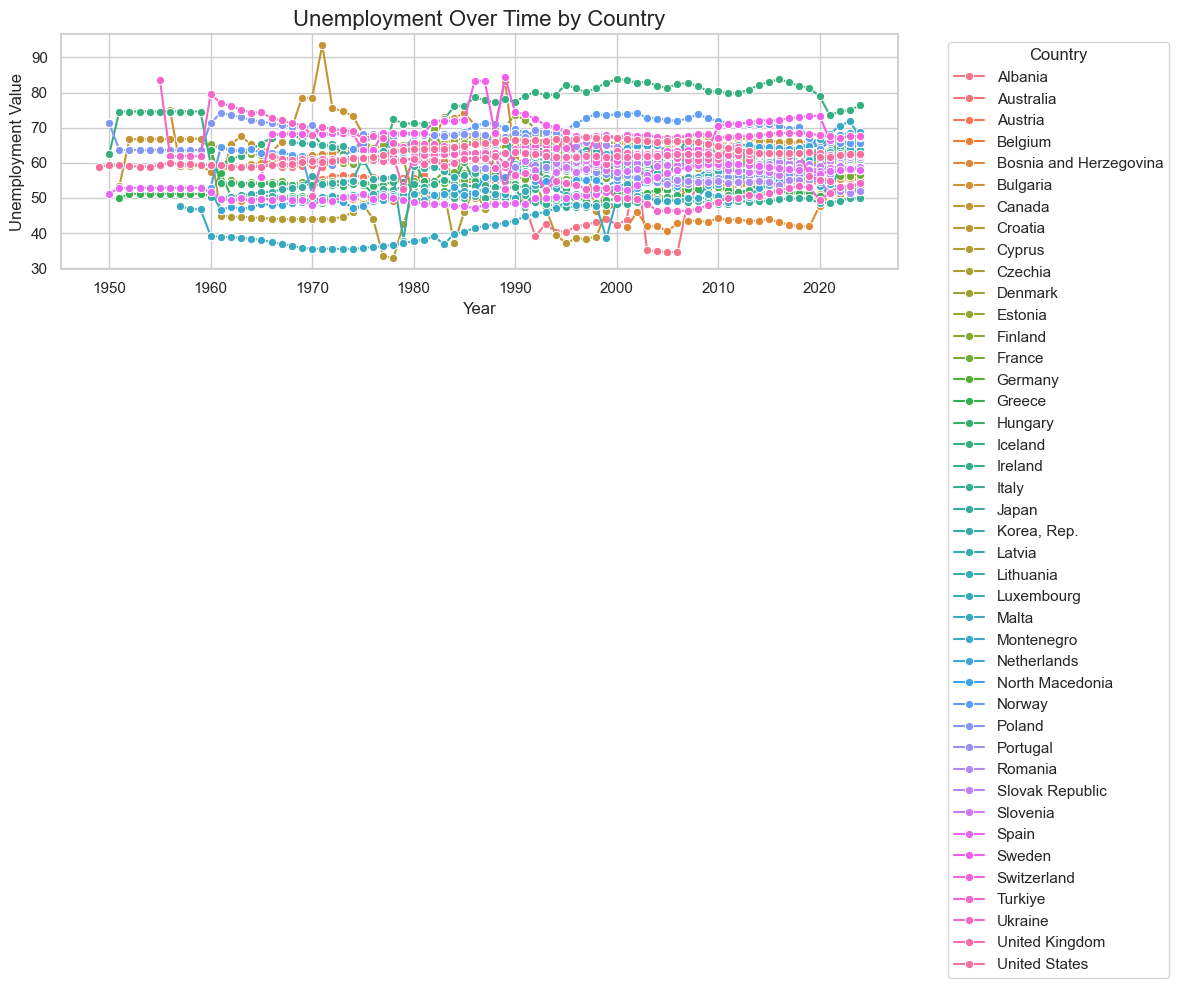

In [95]:
# Code to check all imputed dfs for bias

# Filter the DataFrame to include only 'Educational attainment' indicator
# This step is crucial to ensure you're only plotting the relevant data
educational_data = df_to_impute_lab[
    df_to_impute_lab['Indicator'] == 'Labour force'
].copy() # .copy() to avoid SettingWithCopyWarning if you modify it later

# Ensure 'Year' is numeric for plotting
educational_data['Year'] = pd.to_numeric(educational_data['Year'], errors='coerce')
educational_data.dropna(subset=['Year'], inplace=True) # Drop rows where Year couldn't be converted

# Set up the plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7)) # Adjust figure size for better readability

# Create the line plot using seaborn
# x-axis: Year
# y-axis: Value (assuming this is where the educational attainment data is)
# hue: Country (creates a separate line for each country)
sns.lineplot(
    data=educational_data,
    x='Year',
    y='Value',
    hue='Country',
    marker='o' # Adds markers to data points
)

# Add plot title and labels
plt.title('Unemployment Over Time by Country', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Unemployment Value', fontsize=12)

# Improve legend placement
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [31]:
df_to_impute_educ.to_csv("imputed_educational_att.csv", index=False)

In [40]:
df_to_impute_gini.to_csv("imputed_gini_index.csv", index=False)

In [59]:
df_to_impute_rd.to_csv("imputed_r&d.csv", index=False)

In [91]:
df_to_impute_unemp.to_csv("imputed_unemp.csv", index=False)

In [96]:
df_to_impute_lab.to_csv("imputed_labour_force.csv", index=False)

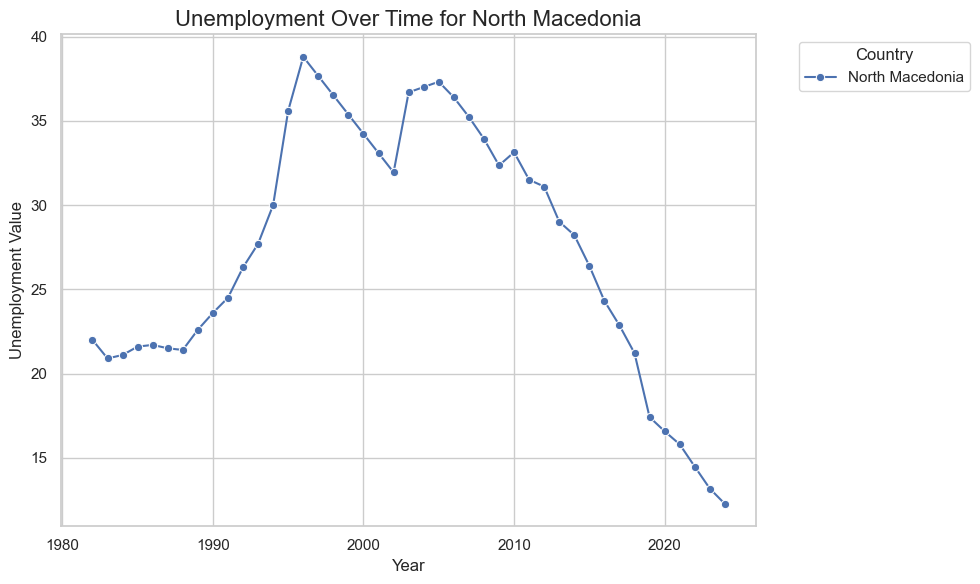

In [86]:
full_model_long_mac = full_model_long
# Focus only on Educational attainment for Ukraine
mask = (full_model_long_mac['Country'] == 'North Macedonia') & (full_model_long_mac['Indicator'] == 'Unemployment')

# Perform linear interpolation for Value within this group
full_model_long_mac.loc[mask, 'Value'] = full_model_long_mac.loc[mask, 'Value'].interpolate(method='linear')

# Ukraine has shown big gaps in data so MICE got to far and imputed higher than 100, Bosnia shows also very biased values for Gini index after imputation

# Step 1: Get the interpolated values for Ukraine & Educational attainment, Bosnia and Herzegovina & Gini Index/Unemployment, North macedonia & Unemployment change between ukr, bos, mon...
full_model_long_mac = full_model_long_mac[
    (full_model_long_mac['Country'] == 'North Macedonia') & 
    (full_model_long_mac['Indicator'] == 'Unemployment')
][['Country', 'Year', 'Indicator', 'Value']]

# Step 2: Remove those rows from df_to_impute_educ
df_to_impute_unemp = df_to_impute_unemp[~(
    (df_to_impute_unemp['Country'] == 'North Macedonia') & 
    (df_to_impute_unemp['Indicator'] == 'Unemployment') &
    (df_to_impute_unemp['Year'].isin(full_model_long_mac['Year']))
)]

# Step 3: Add the interpolated rows back in
df_to_impute_unemp = pd.concat([df_to_impute_unemp, full_model_long_mac], ignore_index=True)

ukraine_educational_data = full_model_long_mac[
    (full_model_long_mac['Indicator'] == 'Unemployment') &
    (full_model_long_mac['Country'] == 'North Macedonia')
].copy() # .copy() to avoid SettingWithCopyWarning

# Ensure 'Year' is numeric for plotting
ukraine_educational_data['Year'] = pd.to_numeric(ukraine_educational_data['Year'], errors='coerce')
ukraine_educational_data.dropna(subset=['Year'], inplace=True) # Drop rows where Year couldn't be converted

# Set up the plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6)) # Adjust figure size for better readability for a single line

# Create the line plot using seaborn
# x-axis: Year
# y-axis: Value (assuming this is where the educational attainment data is)
# Since it's one country, 'hue' is optional, but keeping it can be useful if you later add more
sns.lineplot(
    data=ukraine_educational_data,
    x='Year',
    y='Value',
    hue='Country', # Will just show one color/label for Ukraine
    marker='o' # Adds markers to data points
)

# Add plot title and labels
plt.title('Unemployment Over Time for North Macedonia', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Unemployment Value', fontsize=12)

# Improve legend placement (optional for single hue, but good practice)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()

### Feature Engineering and Final Checks

In [116]:
rd_indicator = pd.read_csv("imputed_r&d.csv")
unemployment_indicator = pd.read_csv("imputed_unemp.csv")
labour_force_indicator = pd.read_csv("imputed_labour_force.csv")
educational_attainment_indicator = pd.read_csv("imputed_educational_att.csv")
gini_index_indicator = pd.read_csv("imputed_gini_index.csv")

unemployment_data = unemployment_indicator[unemployment_indicator['Indicator'] == 'Unemployment'][['Country', 'Year', 'Value']].rename(columns={'Value': 'Unemployment'})
labour_data       = labour_force_indicator[labour_force_indicator['Indicator'] == 'Labour force'][['Country', 'Year', 'Value']].rename(columns={'Value': 'Labour force'})
rd_data           = rd_indicator[rd_indicator['Indicator'] == 'R&D'][['Country', 'Year', 'Value']].rename(columns={'Value': 'R&D'})
educ_data         = educational_attainment_indicator[educational_attainment_indicator['Indicator'] == 'Educational attainment'][['Country', 'Year', 'Value']].rename(columns={'Value': 'Educational attainment'})
gini_data         = gini_index_indicator[gini_index_indicator['Indicator'] == 'Gini index'][['Country', 'Year', 'Value']].rename(columns={'Value': 'Gini Index'})


indicators_to_replace = [
    'R&D',
    'Unemployment',
    'Labour force',
    'Educational attainment',
    'Gini index'
]

# Drop variables before inserting imputed 
full_model_long = full_model_long[~full_model_long['Indicator'].isin(indicators_to_replace)].copy()

# Use pivot_table to reshape the DataFrame
full_model_wide = full_model_long.pivot_table(
    index=['Country', 'Year'],  # These columns will be the new index
    columns='Indicator',           # Values from this column will become new columns
    values='Value'             # Values from this column will populate the new columns
).reset_index()  # Reset the index to make 'Country' and 'Year' regular columns

full_model_wide = full_model_wide.merge(unemployment_data, on=['Country', 'Year'], how='left')
full_model_wide = full_model_wide.merge(labour_data,       on=['Country', 'Year'], how='left')
full_model_wide = full_model_wide.merge(rd_data,           on=['Country', 'Year'], how='left')
full_model_wide = full_model_wide.merge(educ_data,         on=['Country', 'Year'], how='left')
full_model_wide = full_model_wide.merge(gini_data,         on=['Country', 'Year'], how='left')

full_model_wide.to_csv("final_model.csv", index=False)

full_model_wide

,Country,Year,CPI,Capital formation,GDP per cap.,Health expenditure,Merchandise trade,Military_spending,Population,Unemployment,Labour force,R&D,Educational attainment,Gini Index
0,Albania,1960,NaN,NaN,NaN,NaN,NaN,NaN,1608800.0,NaN,NaN,NaN,NaN,NaN
1,Albania,1961,NaN,NaN,NaN,NaN,NaN,NaN,1659800.0,NaN,NaN,NaN,NaN,NaN
2,Albania,1962,NaN,NaN,NaN,NaN,NaN,NaN,1711319.0,NaN,NaN,NaN,NaN,NaN
3,Albania,1963,NaN,NaN,NaN,NaN,NaN,NaN,1762621.0,NaN,NaN,NaN,NaN,NaN
4,Albania,1964,NaN,NaN,NaN,NaN,NaN,NaN,1814135.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,United States,2020,118.690502,21.587737,-3.106490,11672.770508,17.944405,916416.6,331526933.0,8.055,61.746,3.42467,48.090000,39.7
2916,United States,2021,124.266414,21.281794,5.888314,11999.090820,19.803134,906594.3,332048977.0,5.349,61.659,3.48313,47.914421,39.7
2917,United States,2022,134.211206,21.374360,2.136362,12434.433594,20.905642,896121.2,333271411.0,3.650,62.236,3.58623,48.119999,41.3
2918,United States,2023,139.735794,21.390622,2.382669,NaN,18.733583,916014.7,334914895.0,3.638,62.604,NaN,49.142361,NaN


In [7]:
full_model_long = pd.read_csv("full_model_long.csv")
peek_at_data1 = full_model_long[
    (full_model_long['Country'] == 'North Macedonia') &
    (full_model_long['Indicator'] == 'Unemployment')

# Now, you can display the head of the filtered data
#  print(peek_at_data1.head(60))

SyntaxError: incomplete input (1047426019.py, line 7)

#### Final transformation

In [104]:
full_model_wide = pd.read_csv("final_model.csv")

# Calculate population growth per country over time
full_model_wide['Population_growth'] = full_model_wide.groupby('Country')['Population'].pct_change() * 100

# Assuming you have a 'GDP_growth' column in %
def categorize_growth(x):
    if x <= 1:
        return 0  # Low growth
    elif 1 < x <= 4:
        return 1  # Medium growth
    else:
        return 2  # High growth

full_model_wide['GDP_growth_cat'] = full_model_wide['GDP per cap.'].apply(categorize_growth)

Farleft = pd.read_csv("farleft.csv")
Farright = pd.read_csv("farright.csv")
Moderateleft =pd.read_csv("moderateleft.csv")
Moderateright = pd.read_csv("moderateright.csv")

full_model_wide = full_model_wide.merge(Farleft, on=['Country', 'Year'], how='left')
full_model_wide = full_model_wide.merge(Farright, on=['Country', 'Year'], how='left')
full_model_wide = full_model_wide.merge(Moderateleft, on=['Country', 'Year'], how='left')
full_model_wide = full_model_wide.merge(Moderateright, on=['Country', 'Year'], how='left')

# Create two models- reduced and full (witl all variables kept)

reduced_vars = ['Country',
                'Year',
    'Population_growth', 
    'Military_spending', 
'Educational attainment', 
    'Capital formation', 
    'Merchandise trade',
    'GDP_growth_cat', 
    'Farleft', 
    'Farright',
    'Moderateleft', 
    'Moderateright'
]

# Subset reduced model data
reduced_model = full_model_wide[reduced_vars]

# Keep the full model as is
max_model = full_model_wide.drop(columns=['GDP per cap.', 'Country', 'Year'])

C:\Users\tukhy\AppData\Local\Temp\ipykernel_21476\744530871.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  full_model_wide['Population_growth'] = full_model_wide.groupby('Country')['Population'].pct_change() * 100


In [106]:
# Run only to save the dataset 
max_model.to_csv("max_model_final.csv", index=False)

### Initial Data Characterization

#### Summary Statistics

In [36]:
summary = full_model_wide.describe().transpose().reset_index()
summary.rename(columns={'index': 'Variable'}, inplace=True)
summary

,Variable,count,mean,std,min,25%,50%,75%,max
0,Year,2920.0,1.989565e+03,2.037211e+01,1949.000000,1.972000e+03,1.990000e+03,2.007000e+03,2.024000e+03
1,CPI,2264.0,6.848024e+01,5.577018e+01,0.000054,2.611352e+01,7.218997e+01,1.019112e+02,1.322884e+03
2,Capital formation,1989.0,2.369221e+01,4.834588e+00,4.452209,2.067264e+01,2.318424e+01,2.637568e+01,5.322203e+01
3,GDP per cap.,2187.0,2.573581e+00,4.379398e+00,-31.177519,8.510625e-01,2.593928e+00,4.653500e+00,4.784542e+01
4,Health expenditure,970.0,2.867665e+03,2.408884e+03,34.622330,8.273309e+02,2.162439e+03,4.647990e+03,1.243443e+04
5,Merchandise trade,2097.0,6.109981e+01,3.539173e+01,6.420058,3.685646e+01,5.237776e+01,7.826028e+01,2.327421e+02
6,Military_spending,2358.0,3.273244e+04,1.220610e+05,0.000000,1.295150e+03,4.851500e+03,1.463250e+04,1.031257e+06
7,Population,2688.0,2.537338e+07,4.531113e+07,175574.000000,3.159257e+06,8.543260e+06,3.386237e+07,3.349149e+08
8,Unemployment,1634.0,8.356089e+00,5.715682e+00,0.200000,4.688750e+00,6.906000e+00,1.021650e+01,3.880000e+01
9,Labour force,2198.0,5.886736e+01,7.904387e+00,32.720000,5.356454e+01,5.954255e+01,6.352950e+01,9.357000e+01


#### Correlation Analysis

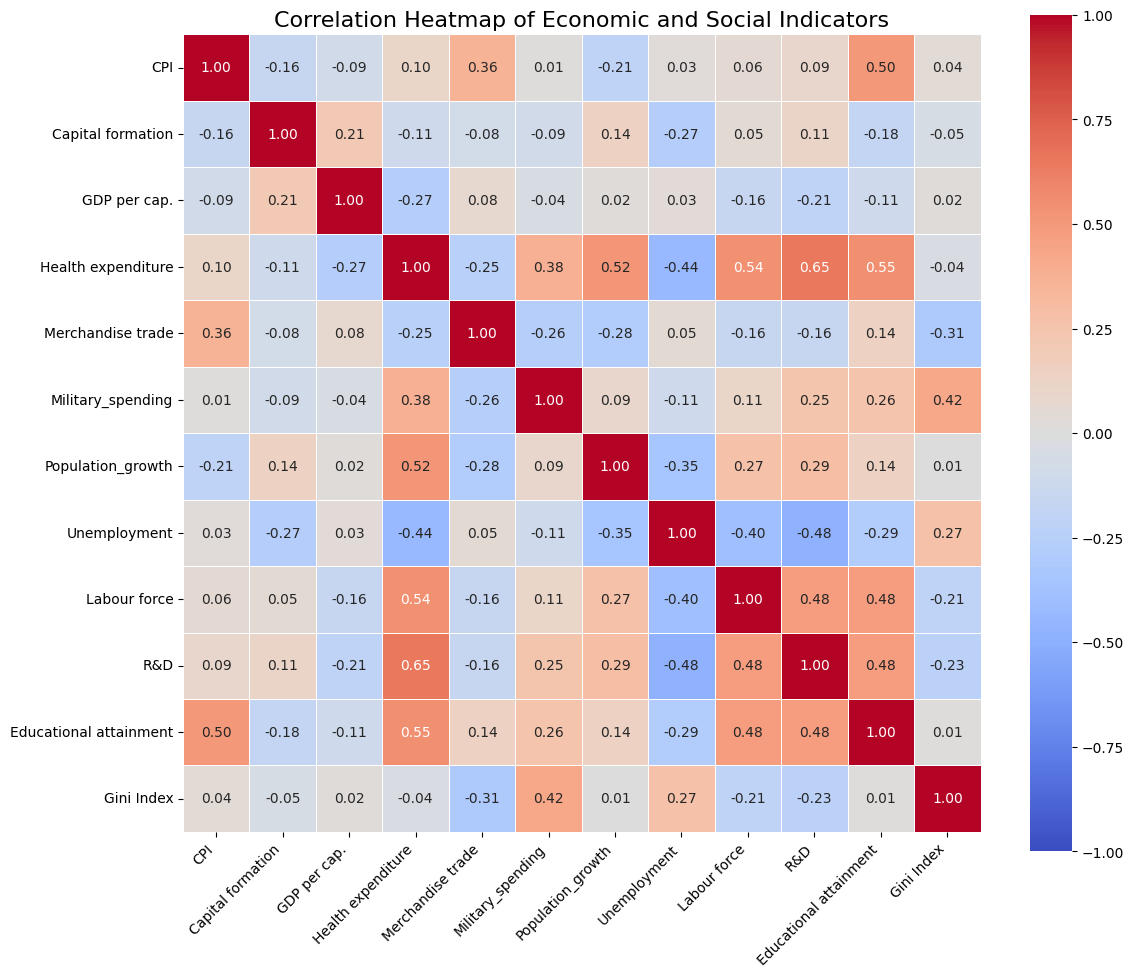

In [37]:
# List of selected variables for correlation
corr_vars = [
    "CPI", "Capital formation", "GDP per cap.", "Health expenditure",
    "Merchandise trade", "Military_spending", "Population_growth",
    "Unemployment", "Labour force", "R&D", "Educational attainment", "Gini Index"
]

# Subset the dataframe with those columns
corr_df = full_model_wide[corr_vars]

# Compute the correlation matrix
corr_matrix = corr_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_matrix, 
    annot=True,            # show correlation coefficients
    fmt=".2f",             # format decimals
    cmap="coolwarm",       # color palette
    vmin=-1, vmax=1,       # fix the color scale
    square=True, 
    linewidths=.5
)

plt.title('Correlation Heatmap of Economic and Social Indicators', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Comparative Modeling and Model Selection

### Preparation before modeling

#### Grouping and binning data: max model

In [45]:
# Drop rows with any NaNs in max_model
max_model = max_model.dropna()

# Assign labels to existing categories

# Map numeric codes to string labels
growth_label_map = {
    0: 'Low Growth',
    1: 'Medium Growth',
    2: 'High Growth'
}

max_model['GDP_growth_label'] = max_model['GDP_growth_cat'].map(growth_label_map)

# Calculate proportion for 'High Growth'
# Count total and 'High Growth' cases
high_growth_count = (max_model['GDP_growth_cat'] == 2).sum()
total_count = max_model['GDP_growth_cat'].notna().sum()

proportion = high_growth_count / total_count
percentage = round(proportion * 100, 2)

text_label = f"High Growth:\n{percentage}% of total"

In [46]:
print("Total observations in max_model:", len(max_model))

Total observations in max_model: 663


C:\Users\tukhy\AppData\Local\Temp\ipykernel_30068\3534756971.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GDP_growth_label', data=max_model, palette='viridis')


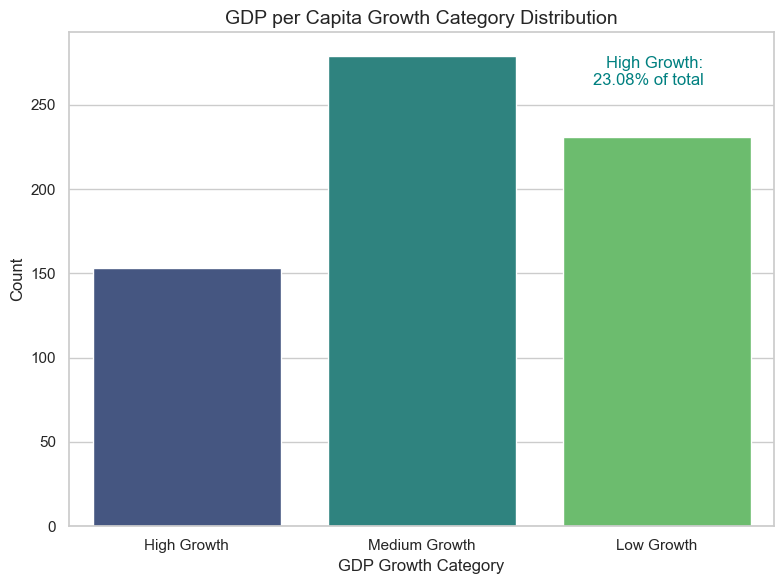

In [40]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Plot countplot (histogram for categorical data)
sns.countplot(x='GDP_growth_label', data=max_model, palette='viridis')

# Add text annotation in top-right corner
plt.annotate(
    text_label, 
    xy=(2.2, max_model['GDP_growth_label'].value_counts().max()), 
    ha='right', va='top', fontsize=12, color='teal'
)

plt.title("GDP per Capita Growth Category Distribution", fontsize=14)
plt.xlabel("GDP Growth Category")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

#### Grouping and binning data: reduced model

In [40]:
print(reduced_model.isna().sum())

Country                     0
Year                        0
Population_growth           0
Military_spending           0
Educational attainment    641
Capital formation           0
Merchandise trade           0
GDP_growth_cat              0
Farleft                     0
Farright                    0
Moderateleft                0
Moderateright               0
dtype: int64


In [39]:
# Prepare reduced model for imputation of educational attainment
no_educ_model = reduced_model.drop(columns=['Educational attainment'])
no_educ_model = no_educ_model.dropna()
reduced_model = reduced_model.loc[no_educ_model.index].copy()

In [41]:
print("Total observations in reduced_model:", len(reduced_model))

Total observations in reduced_model: 1836


In [42]:
random.seed(52)

# Separate ID columns (non-numeric)
id_cols = reduced_model[['Country', 'Year']]

# Select numeric columns for imputation
numeric_cols = reduced_model.select_dtypes(include=np.number).columns

# Initialize IterativeImputer
mice_imputer = IterativeImputer(random_state=42, max_iter=10)

# Fit-transform only numeric data
imputed_array = mice_imputer.fit_transform(reduced_model[numeric_cols])

# Create DataFrame from imputed data with original numeric columns
imputed_numeric_df = pd.DataFrame(imputed_array, columns=numeric_cols, index=reduced_model.index)

# Combine the ID columns back with the imputed numeric data
reduced_model_imputed = pd.concat([id_cols, imputed_numeric_df], axis=1)

# Replace original reduced_model with imputed version (if you want)
reduced_model = reduced_model_imputed

# Check missing values after imputation
print(reduced_model['Educational attainment'].isna().sum())

0


In [10]:
# Map numeric codes to string labels
growth_label_map = {
    0: 'Low Growth',
    1: 'Medium Growth',
    2: 'High Growth'
}

# Map labels
reduced_model['GDP_growth_label'] = reduced_model['GDP_growth_cat'].map(growth_label_map)

# Calculate counts for each category
growth_counts = reduced_model['GDP_growth_cat'].value_counts().sort_index()
total_count = reduced_model['GDP_growth_cat'].notna().sum()

# Calculate proportions and labels
growth_labels = {}
for cat_code, label in growth_label_map.items():
    count = growth_counts.get(cat_code, 0)
    percentage = round(100 * count / total_count, 2)
    growth_labels[label] = f"{label}:\n{percentage}% of total"

# Example: print them
for label_text in growth_labels.values():
    print(label_text)

Low Growth:
27.51% of total
Medium Growth:
42.37% of total
High Growth:
30.12% of total


C:\Users\tukhy\AppData\Local\Temp\ipykernel_63096\3484422896.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(i, bar_heights[i]),


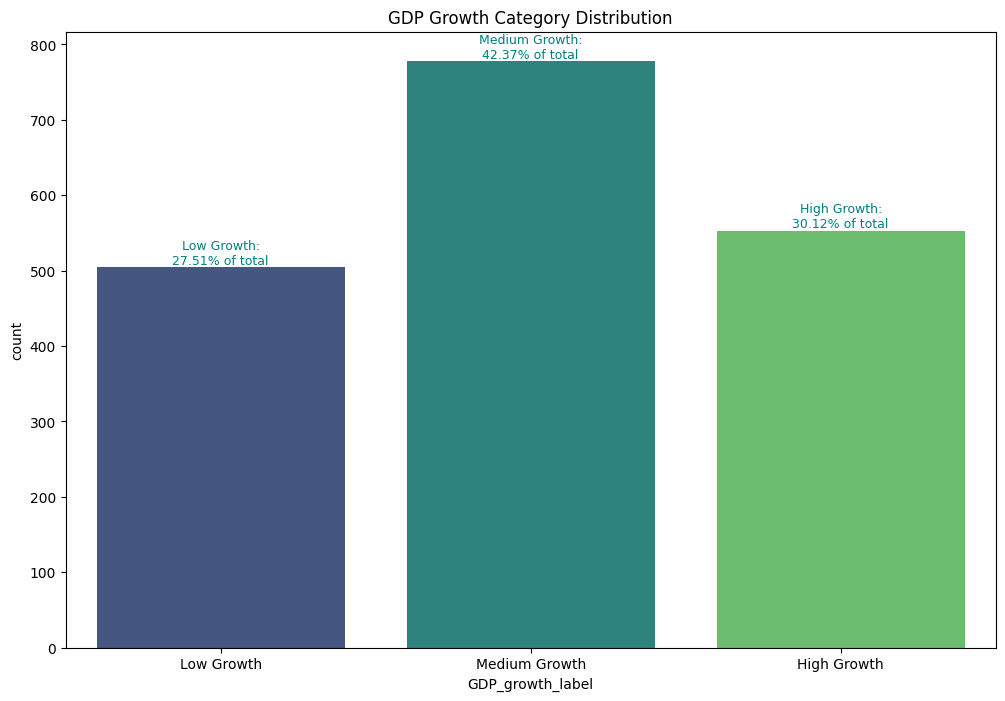

In [11]:
plt.figure(figsize=(12, 8))

# Explicit category order
category_order = ['Low Growth','Medium Growth','High Growth', ]

# Convert column to ordered categorical type
reduced_model['GDP_growth_label'] = pd.Categorical(
    reduced_model['GDP_growth_label'],
    categories=category_order,
    ordered=True
)

# Now plot — seaborn will respect this order
sns.countplot(
    x='GDP_growth_label', 
    hue='GDP_growth_label', 
    data=reduced_model, 
    palette='viridis', 
    legend=False
)

# Annotate bars
bar_heights = reduced_model['GDP_growth_label'].value_counts().reindex(category_order)

for i, (label, text_label) in enumerate(growth_labels.items()):
    plt.annotate(
        text_label,
        xy=(i, bar_heights[i]),
        ha='center', va='bottom',
        fontsize=9, color='teal'
    )

plt.title('GDP Growth Category Distribution')
plt.show()

In [20]:
reduced_model = reduced_model.drop(columns=['GDP_growth_label'])

In [151]:
reduced_model.head()

,Country,Year,Year,Population_growth,Military_spending,Educational attainment,Capital formation,Merchandise trade,GDP_growth_cat,Farleft,Farright,Moderateleft,Moderateright,GDP_growth_label
29,Albania,1989,1989.0,2.724311,348.5,19.706959,32.477620,30.713376,2.0,1.0,0.0,0.0,0.0,High Growth
30,Albania,1990,1990.0,1.815367,358.2,19.240303,30.360947,30.070685,0.0,1.0,0.0,0.0,0.0,Low Growth
31,Albania,1991,1991.0,-0.600996,253.2,11.649837,7.603111,46.382230,0.0,1.0,0.0,0.0,0.0,Low Growth
32,Albania,1992,1992.0,-0.604600,193.6,12.269143,5.656684,93.686512,0.0,1.0,0.0,0.0,0.0,Low Growth
33,Albania,1993,1993.0,-0.608308,177.2,11.547910,13.676137,58.549814,2.0,1.0,0.0,0.0,0.0,High Growth


In [152]:
# Dealing with class imbalance, SMOTE imputation, bins - low, medium, high
# List of feature columns (all except target)
feature_cols = [
    'Population_growth', 
    'Military_spending', 
    'Educational attainment', 
    'Capital formation', 
    'Merchandise trade',
    'Farleft', 
    'Farright', 
    'Moderateleft', 
    'Moderateright'
]

target_col = 'GDP_growth_cat'

# Separate features and target
X = reduced_model[feature_cols]
y = reduced_model[target_col]

# Identify categorical features indices (relative to X columns)
# Since your features look numeric, assume none are categorical here.
# If any are categorical, add their indices, e.g., if 'Educational attainment' is categorical and is within column index 2, then categorical_features=[2]
categorical_features = [5,6,7,8]  # Update if needed

# Initialize SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Apply SMOTENC to create balanced data
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

# Convert back to DataFrame for ease of use
X_resampled_df = pd.DataFrame(X_resampled, columns=feature_cols)
y_resampled_df = pd.Series(y_resampled, name=target_col)

# Combine into one balanced DataFrame
balanced_reduced_model = pd.concat([X_resampled_df, y_resampled_df], axis=1)

print("Before resampling class distribution:")
print(y.value_counts())
print("\nAfter SMOTENC resampling class distribution:")
print(y_resampled_df.value_counts())

Before resampling class distribution:
GDP_growth_cat
1.0    778
2.0    553
0.0    505
Name: count, dtype: int64

After SMOTENC resampling class distribution:
GDP_growth_cat
2.0    778
0.0    778
1.0    778
Name: count, dtype: int64


In [14]:
# List of known categorical variables
manual_categorical_cols = ['Country', 'Year', 'Farleft', 'Farright', 'Moderateleft', 'Moderateright', 'GDP_growth_cat']

# Find categorical columns by dtype and merge with manual list (to avoid missing any)
categorical_cols = list(set(
    reduced_model.select_dtypes(include=['object', 'category']).columns.tolist() + manual_categorical_cols
))

# Now get numerical columns by excluding categorical ones
numerical_cols = reduced_model.columns.difference(categorical_cols)

# Standardize numerical columns only
scaler = StandardScaler()
scaled_numericals = pd.DataFrame(
    scaler.fit_transform(reduced_model[numerical_cols]),
    columns=numerical_cols,
    index=reduced_model.index  # to preserve the original row order
)

# Replace original numerical columns with the scaled versions
reduced_model[numerical_cols] = scaled_numericals

reduced_model.head(40)

,Country,Year,Year,Population_growth,Military_spending,Educational attainment,Capital formation,Merchandise trade,GDP_growth_cat,Farleft,Farright,Moderateleft,Moderateright,GDP_growth_label
29,Albania,1989,1989.0,2.527069,-0.263264,-0.059505,1.866272,-0.893383,2.0,1.0,0.0,0.0,0.0,High Growth
30,Albania,1990,1990.0,1.514617,-0.263187,-0.099120,1.419862,-0.911460,0.0,1.0,0.0,0.0,0.0,Low Growth
31,Albania,1991,1991.0,-1.176917,-0.264028,-0.743491,-3.379810,-0.452687,0.0,1.0,0.0,0.0,0.0,Low Growth
32,Albania,1992,1992.0,-1.180930,-0.264506,-0.690917,-3.790316,0.877775,0.0,1.0,0.0,0.0,0.0,Low Growth
33,Albania,1993,1993.0,-1.185061,-0.264637,-0.752144,-2.098997,-0.110467,2.0,1.0,0.0,0.0,0.0,High Growth
34,Albania,1994,1994.0,-1.189174,-0.264700,-0.682861,-0.997995,-0.644722,2.0,1.0,0.0,0.0,0.0,High Growth
35,Albania,1995,1995.0,-1.193406,-0.264792,-0.693681,-0.495641,-0.680509,2.0,0.0,0.0,1.0,0.0,High Growth
36,Albania,1996,1996.0,-1.197621,-0.264921,-0.644207,-0.386829,-0.750733,2.0,0.0,0.0,1.0,0.0,High Growth
37,Albania,1997,1997.0,-1.201959,-0.265264,-0.465896,-0.740947,-0.779644,0.0,0.0,0.0,1.0,0.0,Low Growth
38,Albania,1998,1998.0,-1.206281,-0.265307,-0.549279,-0.451314,-0.614942,2.0,0.0,0.0,1.0,0.0,High Growth


### Multicollinearity Assessment (VIF)

#### Reduced model

In [123]:
# Define known categorical variables (including target)
categorical_cols = ['Country', 'Year', 'Farleft', 'Farright', 'Moderateleft', 'Moderateright', 'GDP_growth_cat', 'GDP_growth_label']

# Define numerical columns explicitly
numerical_cols = reduced_model.columns.difference(categorical_cols)

# Subset only numerical columns for VIF
X_vif = reduced_model[numerical_cols]

# Add constant/intercept term for VIF computation
X_vif_with_const = sm.add_constant(X_vif)

# Calculate VIF for each numerical feature
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_with_const.values, i)
                   for i in range(X_vif_with_const.shape[1])]

# Display results
print(vif_data)

                  feature        VIF
0                   const  36.497442
1       Capital formation   1.054366
2  Educational attainment   1.249751
3       Merchandise trade   1.333258
4       Military_spending   1.216757
5       Population_growth   1.130779


##### VIF visualisation

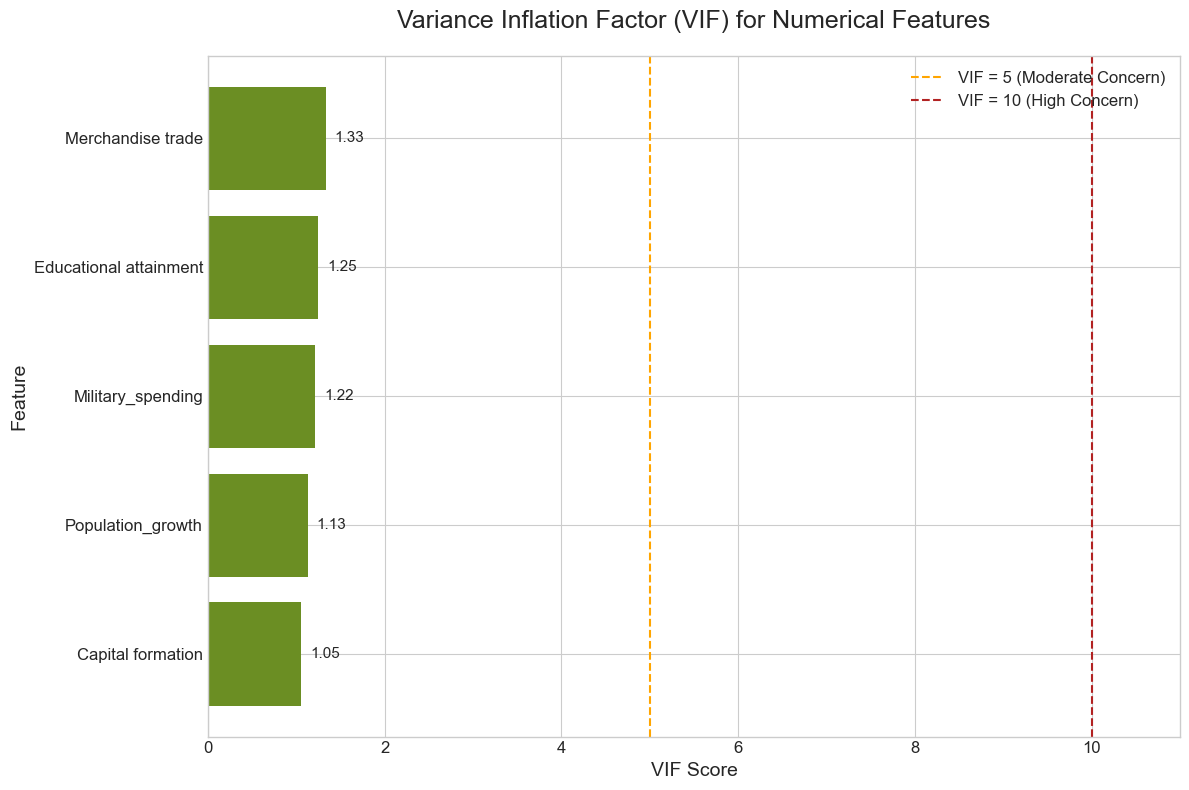

In [124]:
vif_plot_data = vif_data[vif_data['feature'] != 'const'].sort_values('VIF', ascending=False)

# 2. Define a color-coding scheme based on VIF thresholds
def get_vif_color(vif_score):
    if vif_score >= 10:
        return 'firebrick'  # Red for high collinearity
    elif vif_score >= 5:
        return 'orange'     # Orange for moderate/potential concern
    else:
        return 'olivedrab'  # Green for low/acceptable collinearity

vif_plot_data['color'] = vif_plot_data['VIF'].apply(get_vif_color)

# 3. Create the horizontal bar plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(
    vif_plot_data['feature'],
    vif_plot_data['VIF'],
    color=vif_plot_data['color']
)

# 4. Customize the plot for clarity and presentation
ax.set_title('Variance Inflation Factor (VIF) for Numerical Features', fontsize=18, pad=20)
ax.set_xlabel('VIF Score', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Invert y-axis so the highest VIF is at the top
ax.invert_yaxis()

# Add vertical lines for common VIF thresholds
ax.axvline(x=5, color='orange', linestyle='--', linewidth=1.5, label='VIF = 5 (Moderate Concern)')
ax.axvline(x=10, color='firebrick', linestyle='--', linewidth=1.5, label='VIF = 10 (High Concern)')

# Add the VIF value as a label on each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
            va='center', ha='left', fontsize=11)

# Adjust plot limits and add legend
ax.set_xlim(0, max(vif_plot_data['VIF'].max() * 1.1, 11)) # Ensure space for labels and threshold lines
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### Max model

In [49]:
# Drop excess column
max_model = max_model.drop(columns=['Population'])

# Define known categorical variables (including target)
categorical_cols = ['Country', 'Year', 'Farleft', 'Farright', 'Moderateleft', 'Moderateright', 'GDP_growth_cat', 'GDP_growth_label']

# Define numerical columns explicitly
numerical_cols_max = max_model.columns.difference(categorical_cols)

# Subset only numerical columns for VIF
X_vif_max = max_model[numerical_cols_max]

# Add constant/intercept term for VIF computation
X_vif_with_const_max = sm.add_constant(X_vif_max)

# Calculate VIF for each numerical feature
vif_data_max = pd.DataFrame()
vif_data_max['feature'] = X_vif_with_const_max.columns
vif_data_max['VIF'] = [variance_inflation_factor(X_vif_with_const_max.values, i)
                   for i in range(X_vif_with_const_max.shape[1])]

# Display results
print(vif_data_max)

                   feature         VIF
0                    const  393.059168
1                      CPI    1.140209
2        Capital formation    1.203912
3   Educational attainment    1.801298
4               Gini Index    1.973504
5       Health expenditure    2.794787
6             Labour force    1.939744
7        Merchandise trade    1.605191
8        Military_spending    1.684712
9        Population_growth    1.697702
10                     R&D    2.035478
11            Unemployment    1.607486


### Cross-Validation Framework Setup

In [ ]:
# Run only to save the initial dataset for modelling
reduced_model.to_csv("reduced_model_final.csv", index=False)

In [3]:
# Drop identifier columns
reduced_model = pd.read_csv('reduced_model_final.csv')

# Ensure GDP_growth is categorical with correct order and labels
reduced_model['GDP_growth_cat'] = pd.Categorical(
    reduced_model['GDP_growth_cat'],
    categories=[0, 1, 2],
    ordered=True
)

# Separate features and target
X = reduced_model.drop('GDP_growth_cat', axis=1)
y = reduced_model['GDP_growth_cat']

# Reserve 20% as final holdout test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
k = 5  # splitting the data into 5 folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize storage for results
results = {
    'logreg': {'coef': [], 'perm': [], 'shap': [], 'accuracy': [], 'f1_macro': [], 'roc_auc_macro': []}, # ## NEW ## Added f1 and roc_auc
    'rf':     {'builtin': [], 'perm': [], 'shap': [], 'accuracy': [], 'f1_macro': [], 'roc_auc_macro': []},
    'nn':     {'perm': [], 'shap': [], 'accuracy': [], 'f1_macro': [], 'roc_auc_macro': []}
}

# Wrapper to make Keras model sklearn-compatible
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    # no‑op fit so sklearn is happy
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        proba = self.model.predict(X, verbose = 0)
        return np.argmax(proba, axis=1)
    def predict_proba(self, X):
        return self.model.predict(X)
        

def create_nn(input_dim, n_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Model Training and Evaluation Loop

#### Logistic Regression Loop

In [21]:
# --- 1) Logistic Regression Loop ---
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"LogReg Fold {fold}/{k}")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # preprocess
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_val_s = scaler.transform(X_val)
    X_tr_r, y_tr_r = SMOTE(random_state=42).fit_resample(X_tr_s, y_tr)
    
    # fit & collect
    logreg = LogisticRegression(max_iter=1000, random_state=42).fit(X_tr_r, y_tr_r)
    
    # Get predictions on the validation set
    y_pred = logreg.predict(X_val_s)
    y_proba = logreg.predict_proba(X_val_s)
    
    results['logreg']['coef'].append(np.abs(logreg.coef_).mean(axis=0))
    accuracy = logreg.score(X_val_s, y_val)  
    results['logreg']['accuracy'].append(accuracy)   
    
    f1_macro = f1_score(y_val, y_pred, average='macro')
    results['logreg']['f1_macro'].append(f1_macro)
    
    roc_auc_macro = roc_auc_score(y_val, y_proba, multi_class='ovr', average='macro')
    results['logreg']['roc_auc_macro'].append(roc_auc_macro)

    perm = permutation_importance(logreg, X_val_s, y_val, n_repeats=10, random_state=42)
    results['logreg']['perm'].append(perm.importances_mean)
    
    explainer = shap.LinearExplainer(logreg, X_tr_r) 
    shap_values = explainer(X_val_s) 
    shap_importance = np.mean(np.abs(shap_values.values), axis=0) 
     
    # 4. Store the result for this fold
    results['logreg']['shap'].append(shap_importance)
results['logreg']['shap'] = [shap_array.mean(axis=1) for shap_array in results['logreg']['shap']]

LogReg Fold 1/5
LogReg Fold 2/5
LogReg Fold 3/5
LogReg Fold 4/5
LogReg Fold 5/5


#### Random Forest Loop

In [5]:
# --- 2) Random Forest Loop ---
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"RF Fold {fold}/{k}")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # preprocess
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_val_s = scaler.transform(X_val)
    X_tr_r, y_tr_r = SMOTE(random_state=42).fit_resample(X_tr_s, y_tr)

    # fit & collect
    rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_tr_r, y_tr_r)
    # Get predictions on the validation set
    y_pred = rf.predict(X_val_s)
    y_proba = rf.predict_proba(X_val_s)
    
    results['rf']['builtin'].append(rf.feature_importances_)
    accuracy = rf.score(X_val_s, y_val)                    
    results['rf']['accuracy'].append(accuracy) 
    
    f1_macro = f1_score(y_val, y_pred, average='macro')
    results['rf']['f1_macro'].append(f1_macro)
    
    roc_auc_macro = roc_auc_score(y_val, y_proba, multi_class='ovr', average='macro')
    results['rf']['roc_auc_macro'].append(roc_auc_macro)
    perm = permutation_importance(rf, X_val_s, y_val, n_repeats=10, random_state=42)
    results['rf']['perm'].append(perm.importances_mean)
    
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer(X_val_s)  #  results['logreg']['shap'].append(shap_importance) # <-- NEW
    shap_importance = np.mean(np.abs(shap_values.values), axis=0)
    results['rf']['shap'].append(shap_importance)
results['rf']['shap'] = [shap_array.mean(axis=1) for shap_array in results['rf']['shap']]

RF Fold 1/5
RF Fold 2/5
RF Fold 3/5
RF Fold 4/5
RF Fold 5/5


#### Neural Network Loop

In [ ]:
# --- 3) Neural Network Loop ---
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"NN Fold {fold}/{k}")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # preprocess
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = scaler.transform(X_tr)
    X_val_s = scaler.transform(X_val)
    X_tr_r, y_tr_r = SMOTE(random_state=42).fit_resample(X_tr_s, y_tr)

    # Force numeric dtypes for Keras
    X_tr_r = X_tr_r.astype('float32')
    y_tr_r = y_tr_r.astype('int32')
    X_val_s = X_val_s.astype('float32') 
    
    # Train NN
    nn = create_nn(X_tr_r.shape[1], n_classes=3)
    nn.fit(X_tr_r, y_tr_r, epochs=20, batch_size=32, verbose=0)

    # wrap & collect
    wrapped = KerasClassifierWrapper(nn)
    # Get predictions on the validation set
    y_pred = wrapped.predict(X_val_s)
    y_proba = wrapped.predict_proba(X_val_s)
    
    accuracy = wrapped.score(X_val_s.astype('float32'), y_val)
    results['nn']['accuracy'].append(accuracy)    

    f1_macro = f1_score(y_val, y_pred, average='macro')
    results['nn']['f1_macro'].append(f1_macro)
    
    roc_auc_macro = roc_auc_score(y_val, y_proba, multi_class='ovr', average='macro')
    results['nn']['roc_auc_macro'].append(roc_auc_macro)
    
    perm = permutation_importance(wrapped, X_val_s, y_val,
                                  n_repeats=10, random_state=42, scoring='accuracy')
    results['nn']['perm'].append(perm.importances_mean)

        # SHAP values for Neural Network (KernelExplainer)
    explainer = shap.KernelExplainer(wrapped.predict, X_tr_r[:100], silent=True)
    shap_values = explainer(X_val_s[:100])
    shap_importance = np.mean(np.abs(shap_values.values), axis=0)
    results['nn']['shap'].append(shap_importance)
results['nn']['shap'] = [shap_array.mean(axis=1) for shap_array in results['nn']['shap']]

### Model Selection: Performance Comparison

#### Cross-Validation Performance Summary (Accuracy, F1, ROC AUC)

In [100]:

# Assume 'results' dictionary is populated from your CV loops
# Assume X is your feature DataFrame, e.g., X = reduced_model.drop('GDP_growth_cat', axis=1)

# --- Part 1: Create a Performance Metrics Summary Table ---

# This table gives a high-level overview of which model performed best.
performance_data = {}
for model_name, model_results in results.items():
    # Calculate mean and std deviation for each metric across the 5 folds
    acc_mean = np.mean(model_results['accuracy'])
    acc_std = np.std(model_results['accuracy'])
    
    # Check if f1_macro and roc_auc_macro exist before calculating
    f1_mean = np.mean(model_results['f1_macro']) if 'f1_macro' in model_results and model_results['f1_macro'] else 'N/A'
    f1_std = np.std(model_results['f1_macro']) if 'f1_macro' in model_results and model_results['f1_macro'] else ''
    
    roc_mean = np.mean(model_results['roc_auc_macro']) if 'roc_auc_macro' in model_results and model_results['roc_auc_macro'] else 'N/A'
    roc_std = np.std(model_results['roc_auc_macro']) if 'roc_auc_macro' in model_results and model_results['roc_auc_macro'] else ''

    # Store formatted strings (Mean ± Std)
    performance_data[model_name.upper()] = {
        'Accuracy': f"{acc_mean:.4f} ± {acc_std:.4f}",
        'Macro F1-Score': f"{f1_mean:.4f} ± {f1_std:.4f}" if isinstance(f1_mean, float) else f1_mean,
        'Macro ROC AUC': f"{roc_mean:.4f} ± {roc_std:.4f}" if isinstance(roc_mean, float) else roc_mean
    }

performance_df = pd.DataFrame.from_dict(performance_data, orient='index')

print("--- Model Performance Summary (Mean ± Std across 5 folds) ---")
display(performance_df)


# --- Part 2: Create a Detailed Feature Importance Table ---

# This table shows the contribution of each variable, allowing for deep analysis.
feature_names = X.columns
importance_data = {}
model_method_map = {
    'Logistic Regression': {'logreg': ['coef', 'perm', 'shap']},
    'Random Forest': {'rf': ['builtin', 'perm', 'shap']},
    'Neural Network': {'nn': ['perm', 'shap']}
}

# Use a consistent set of methods for comparison where possible
for display_name, models in model_method_map.items():
    for model_code, methods in models.items():
        for method in methods:
            # Create a unique column name like ('Random Forest', 'SHAP')
            col_name = (display_name, method.capitalize())
            # Calculate the mean importance across folds for all features
            mean_importances = np.mean(results[model_code][method], axis=0)
            importance_data[col_name] = mean_importances

# Create the multi-index DataFrame
importance_df = pd.DataFrame(importance_data, index=feature_names)

# --- Sort the table to tell a story ---
# Let's sort by the most reliable method (SHAP) from your likely best model (Random Forest)
# This makes the most important features rise to the top.
if ('Random Forest', 'SHAP') in importance_df.columns:
    importance_df = importance_df.sort_values(by=('Random Forest', 'SHAP'), ascending=False)
elif ('Random Forest', 'Permutation') in importance_df.columns:
     importance_df = importance_df.sort_values(by=('Random Forest', 'Permutation'), ascending=False)


print("\n\n--- Feature Importance Summary (Mean across 5 folds) ---")
# Use styling to make the table even easier to read
display(importance_df.style.background_gradient(cmap='viridis', axis=0)
                          .set_caption("Feature Importances by Model and Method")
                          .format("{:.4f}"))

--- Model Performance Summary (Mean ± Std across 5 folds) ---


,Accuracy,Macro F1-Score,Macro ROC AUC
LOGREG,0.4720 ± 0.0336,0.4721 ± 0.0337,0.6575 ± 0.0201
RF,0.5089 ± 0.0191,0.5013 ± 0.0152,0.6786 ± 0.0142
NN,0.4945 ± 0.0457,0.4938 ± 0.0444,0.6746 ± 0.0290




--- Feature Importance Summary (Mean across 5 folds) ---


#### Visual Comparison of Model Performance

##### Logistic Regression (using absolute coefficients)

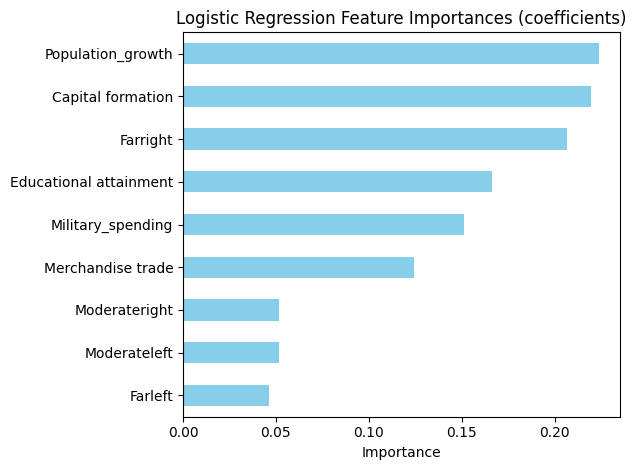

In [44]:
coefs = pd.Series(np.abs(logreg.coef_).mean(axis=0), index=X_train.columns)
coefs_sorted = coefs.sort_values()
coefs_sorted.plot(kind='barh', color='skyblue')
plt.title('Logistic Regression Feature Importances (coefficients)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

#####  Random Forest 

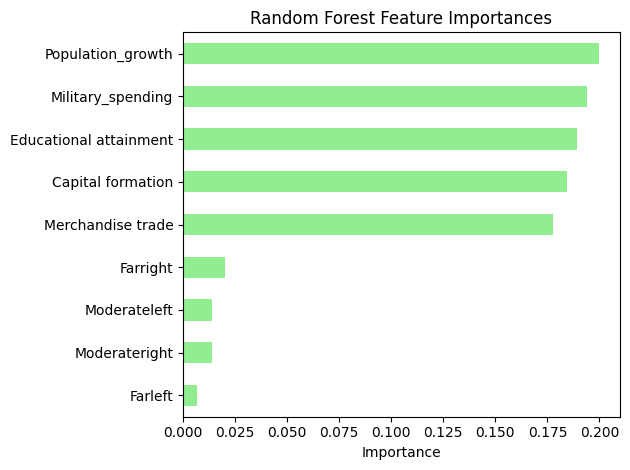

In [45]:
# Assuming rf is your trained RandomForestClassifier and X_train your DataFrame of features
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

##### Neural Network (using permutation importance)

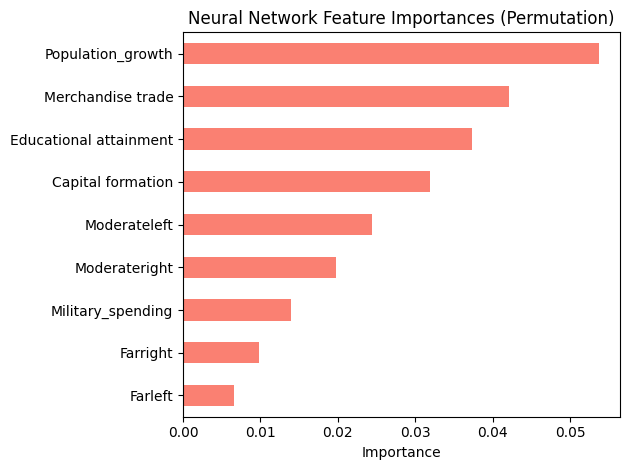

In [68]:
nn_perm_importance = np.mean(results['nn']['perm'], axis=0)
# Assuming nn_perm_importance is your averaged permutation importance array
nn_importances = pd.Series(nn_perm_importance, index=X_train.columns)
nn_importances_sorted = nn_importances.sort_values()
nn_importances_sorted.plot(kind='barh', color='salmon')
plt.title('Neural Network Feature Importances (Permutation)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

##### SHAP values across models

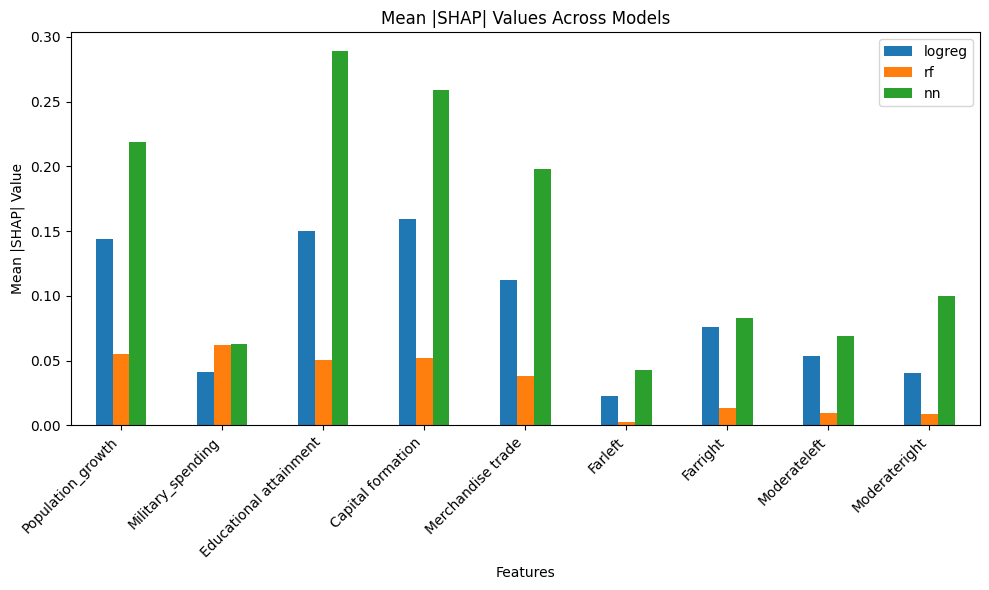

In [101]:
# 1) List your models
models = ['logreg', 'rf', 'nn']  
n_feats = X_train.shape[1]
feature_names = X_train.columns

# 2) Build shap_means so each entry is length‐n_feats
shap_means = {}
for m in models:
    arr = np.array(results[m]['shap'])
    # arr should have shape (n_folds, n_feats)
    if arr.ndim != 2 or arr.shape[1] != n_feats:
        raise ValueError(
            f"results['{m}']['shap'] must be of shape (n_folds, {n_feats}), "
            f"but got {arr.shape}"
        )
    shap_means[m] = arr.mean(axis=0)   # now shape == (n_feats,)

# 3) Build DataFrame with features as index, models as columns
shap_df = pd.DataFrame(shap_means, index=feature_names)

# 4) Plot grouped bar chart
ax = shap_df.plot.bar(figsize=(10, 6))
ax.set_title('Mean |SHAP| Values Across Models')
ax.set_ylabel('Mean |SHAP| Value')
ax.set_xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


##### Cross-Model Feature Importance

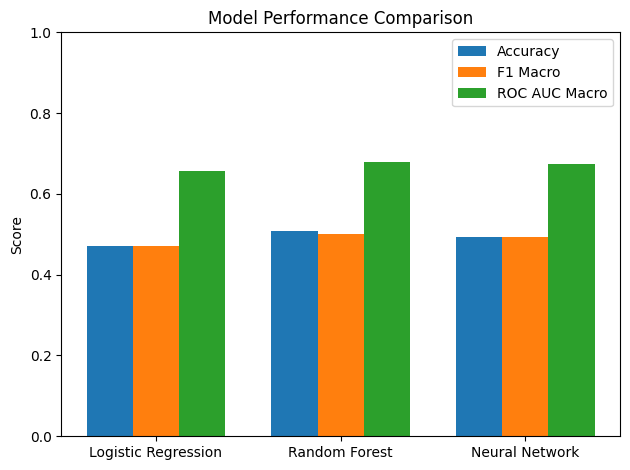

In [111]:
# Example metrics (replace with your actual results)
model_names = ['Logistic Regression', 'Random Forest', 'Neural Network']
accuracy = [0.472, 0.5089, 0.4945]
f1_macro = [0.4721, 0.5013, 0.4938]
roc_auc_macro = [0.6575, 0.6786, 0.6746]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, accuracy, width, label='Accuracy')
ax.bar(x, f1_macro, width, label='F1 Macro')
ax.bar(x + width, roc_auc_macro, width, label='ROC AUC Macro')

ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.set_title('Model Performance Comparison')
ax.legend()
plt.tight_layout()
plt.show()

## Final Model Evaluation and In-Depth Interpretation

### Final Model Training on Full Training Data

In [7]:
# Assume X_train, y_train, X_test, y_test are already defined
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

final_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf_model.fit(X_train_resampled, y_train_resampled)

print("Final model trained on the full training dataset.")

y_final_pred = final_rf_model.predict(X_test_scaled)
y_final_proba = final_rf_model.predict_proba(X_test_scaled)

final_accuracy = accuracy_score(y_test, y_final_pred)
final_f1_macro = f1_score(y_test, y_final_pred, average='macro')
final_roc_auc_macro = roc_auc_score(y_test, y_final_proba, multi_class='ovr', average='macro')

print(f"\n--- Final Model Performance on Holdout Test Set ---")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Macro F1-Score: {final_f1_macro:.4f}")
print(f"Macro ROC AUC: {final_roc_auc_macro:.4f}")

print("\n--- Calculating Final Feature Importances ---")

# 1. Built-in Importance (Gini Importance)
builtin_importance = final_rf_model.feature_importances_

# 2. Permutation Importance (on the test set for an unbiased view)
perm_result = permutation_importance(
    final_rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
perm_importance = perm_result.importances_mean

# 3. SHAP Importance (most robust method)
explainer = shap.TreeExplainer(final_rf_model)
# Calculate SHAP values on the test set
shap_values = explainer(X_test_scaled)
# For multi-class, we take the mean absolute value across all classes
shap_importance = np.mean(np.abs(shap_values.values), axis=(0, 2))

# Combine all importances into a single DataFrame for easy comparison
feature_names = X.columns # Get feature names from the original DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Built-in': builtin_importance,
    'Permutation': perm_importance,
    'SHAP': shap_importance
})

# Sort the DataFrame by SHAP importance to highlight the most influential features
importance_df = importance_df.sort_values(by='SHAP', ascending=False).reset_index(drop=True)

print("\n--- Final Feature Importance Summary ---")
display(importance_df)

Final model trained on the full training dataset.

--- Final Model Performance on Holdout Test Set ---
Accuracy: 0.5136
Macro F1-Score: 0.5099
Macro ROC AUC: 0.7144

--- Calculating Final Feature Importances ---

--- Final Feature Importance Summary ---


,Feature,Built-in,Permutation,SHAP
0,Military_spending,0.193881,0.053533,0.059546
1,Capital formation,0.184500,0.059783,0.054759
2,Population_growth,0.199868,0.028533,0.053467
3,Educational attainment,0.189445,0.033696,0.047176
4,Merchandise trade,0.177695,0.029620,0.037345
5,Farright,0.020076,0.018750,0.019068
6,Moderateleft,0.014085,-0.009239,0.008975
7,Moderateright,0.013756,-0.004891,0.008073
8,Farleft,0.006694,0.005978,0.002205


### Feature importance visualization

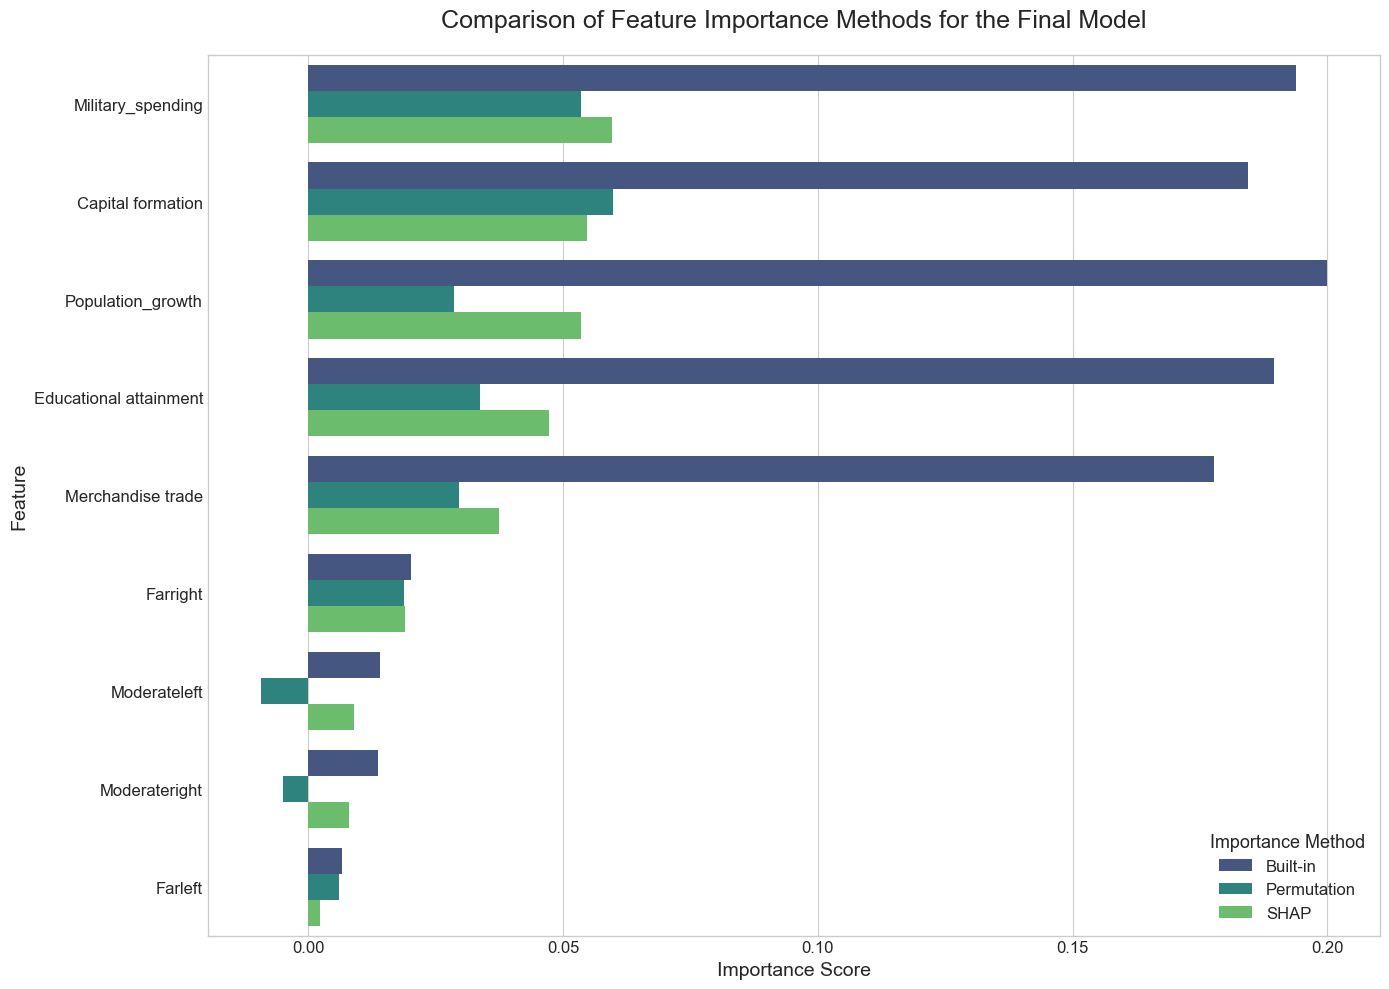

In [121]:
# 1. Reshape the data from "wide" to "long" format for easy plotting with seaborn
melted_df = pd.melt(
    importance_df,
    id_vars=['Feature'],
    value_vars=['Built-in', 'Permutation', 'SHAP'],
    var_name='Method',
    value_name='Importance'
)

# 2. Create the plot
plt.style.use('seaborn-v0_8-whitegrid') # Use a clean, professional style
fig, ax = plt.subplots(figsize=(14, 10)) # Make the figure taller to accommodate all features

# Create the grouped horizontal bar plot
sns.barplot(
    data=melted_df,
    x='Importance',
    y='Feature',
    hue='Method', # This creates the grouping
    palette='viridis', # A nice color palette
    ax=ax
)

# 3. Customize the plot for clarity and presentation
ax.set_title('Comparison of Feature Importance Methods for the Final Model', fontsize=18, pad=20)
ax.set_xlabel('Importance Score', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Improve the legend
plt.legend(title='Importance Method', fontsize=12, title_fontsize=13)
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()

### Confusion matrix


--- Generating Final Confusion Matrix ---


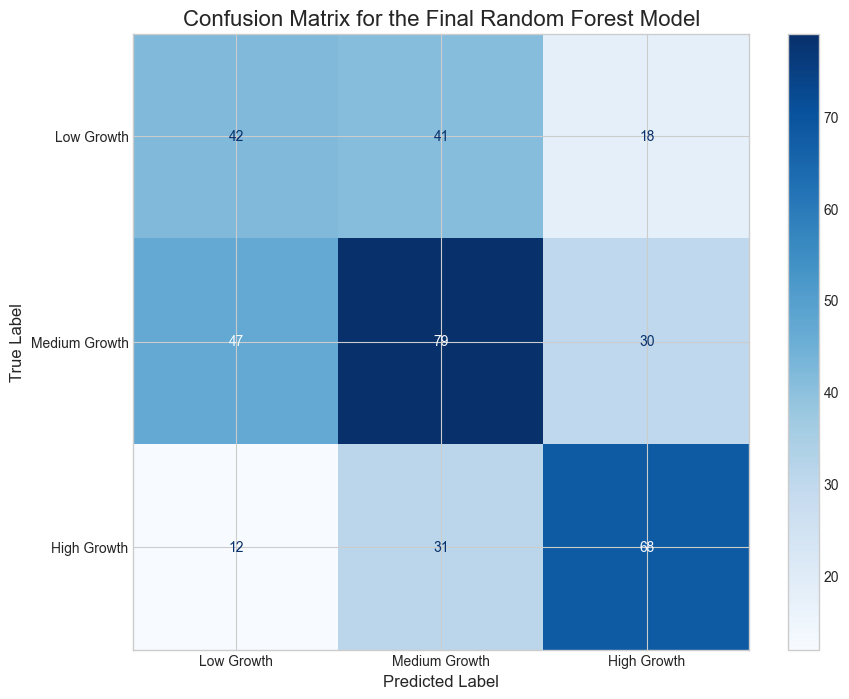


Raw Confusion Matrix (Numbers):
[[42 41 18]
 [47 79 30]
 [12 31 68]]


In [28]:
print("\n--- Generating Final Confusion Matrix ---")

# Define the display labels for your classes
class_labels = ['Low Growth', 'Medium Growth', 'High Growth']

# The from_estimator method is the most convenient way to plot
fig, ax = plt.subplots(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay.from_estimator(
    estimator=final_rf_model,
    X=X_test_scaled,
    y=y_test,
    display_labels=class_labels,
    cmap=plt.cm.Blues, # A standard, clean color map
    ax=ax
)

# Customize the plot for your thesis
ax.set_title("Confusion Matrix for the Final Random Forest Model", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
plt.show()

# You can also get the raw numbers if you need them for a table
cm_raw = confusion_matrix(y_test, y_final_pred)
print("\nRaw Confusion Matrix (Numbers):")
print(cm_raw)

### Partial dependence plots (PDPs)


--- Generating Combined Partial Dependence Plot for Military Spending ---


C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has fe

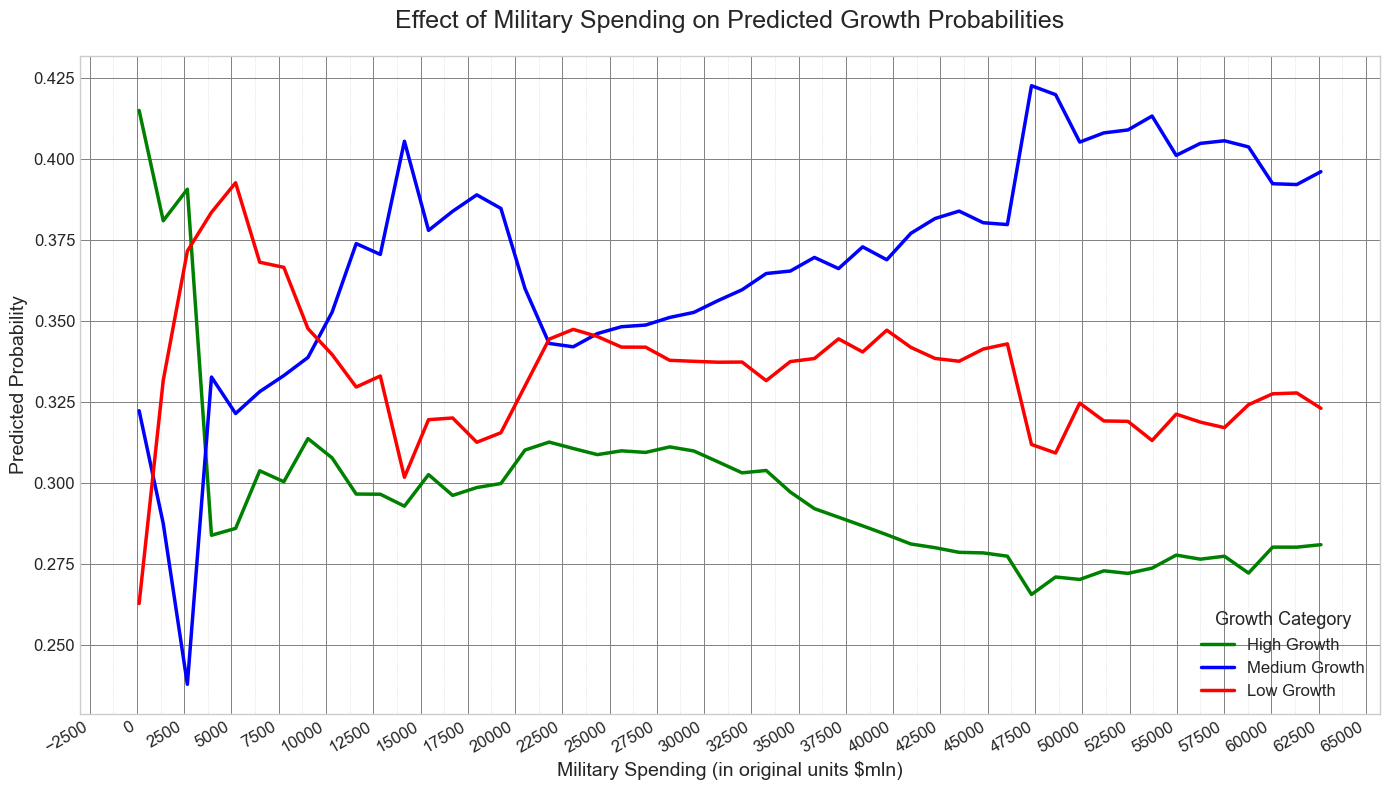

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import partial_dependence

# ==============================================================================
# --- Combined PDP for All Growth Classes vs. Military Spending ---
# ==============================================================================
print("\n--- Generating Combined Partial Dependence Plot for Military Spending ---")

# Step 1: Calculate the partial dependence data for ALL classes at once
pdp_results = partial_dependence(
    estimator=final_rf_model,
    X=X_train_scaled_df,
    features=['Military_spending'],
    response_method='predict_proba', # This gets the probabilities for all classes
    grid_resolution=50
)

# Step 2: Extract the data for each component
# The x-axis values (in scaled units)
scaled_x_values = pdp_results['grid_values'][0]
# The y-axis values (predicted probabilities for each class)
y_values_all_classes = pdp_results['average']

# Separate the probabilities for each class
y_low_growth = y_values_all_classes[0]
y_medium_growth = y_values_all_classes[1]
y_high_growth = y_values_all_classes[2]

# Step 3: Inverse-transform the x-axis values to their original, interpretable scale
military_spending_idx = X_train.columns.get_loc('Military_spending')
dummy_array = np.zeros((len(scaled_x_values), X_train_scaled_df.shape[1]))
dummy_array[:, military_spending_idx] = scaled_x_values
unscaled_x_values = scaler.inverse_transform(dummy_array)[:, military_spending_idx]


# Step 4: Create the combined plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each line on the same axes
ax.plot(unscaled_x_values, y_high_growth, label='High Growth', color='green', linewidth=2.5)
ax.plot(unscaled_x_values, y_medium_growth, label='Medium Growth', color='blue', linewidth=2.5)
ax.plot(unscaled_x_values, y_low_growth, label='Low Growth', color='red', linewidth=2.5)

# Customize the plot for clarity and presentation
ax.set_title("Effect of Military Spending on Predicted Growth Probabilities", fontsize=18, pad=20)
ax.set_xlabel("Military Spending (in original units $mln)", fontsize=14)
ax.set_ylabel("Predicted Probability", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.legend(title='Growth Category', fontsize=12, title_fontsize=13)

# ==============================================================================
# --- NEW: Enhance X-axis visibility ---
# ==============================================================================
from matplotlib.ticker import AutoMinorLocator

# Method 1: Increase the number of major ticks.
# The `plt.locator_params` function lets you suggest a number of ticks.
# 'tight=True' helps ensure the ticks are within the data range.
ax.locator_params(axis='x', nbins=30) # Suggest 10 ticks instead of the default (usually ~5-6)

# Method 2: Add minor gridlines for even more detail.
# This adds lighter gridlines between the main ones.
ax.xaxis.set_minor_locator(AutoMinorLocator(2)) # Add 1 minor tick between each major tick (2 intervals)
ax.grid(True, which='major', linestyle='-', linewidth='0.7', color='gray') # Style for major gridlines
ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray') # Style for minor gridlines

# Rotate x-tick labels slightly if they overlap
plt.xticks(rotation=30, ha='right')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()


--- Generating Combined Partial Dependence Plot for Educational attainment ---


C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has fe

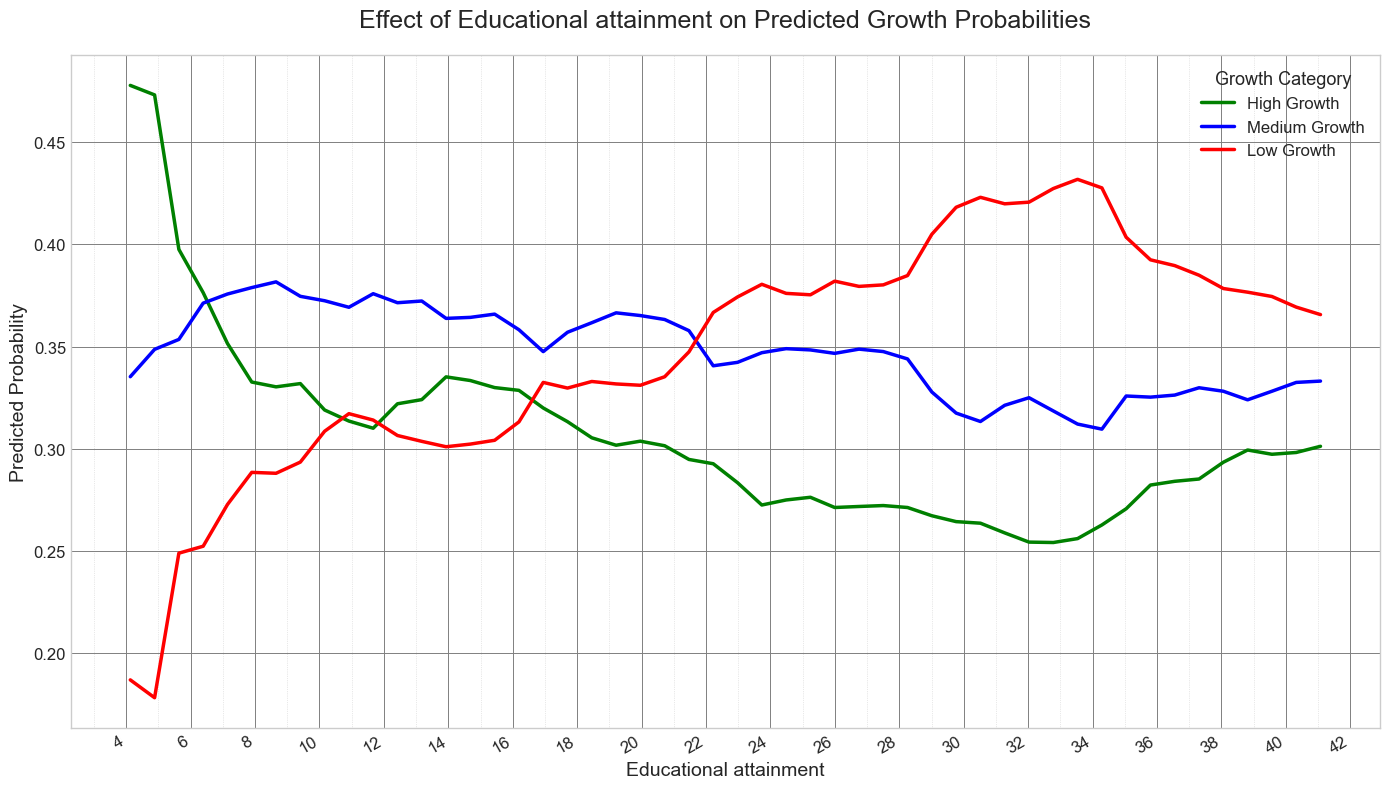

In [21]:
# ==============================================================================
# --- Combined PDP for All Growth Classes vs. Military Spending ---
# ==============================================================================
print("\n--- Generating Combined Partial Dependence Plot for Educational attainment ---")

# Step 1: Calculate the partial dependence data for ALL classes at once
pdp_results = partial_dependence(
    estimator=final_rf_model,
    X=X_train_scaled_df,
    features=['Educational attainment'],
    response_method='predict_proba', # This gets the probabilities for all classes
    grid_resolution=50
)

# Step 2: Extract the data for each component
# The x-axis values (in scaled units)
scaled_x_values = pdp_results['grid_values'][0]
# The y-axis values (predicted probabilities for each class)
y_values_all_classes = pdp_results['average']

# Separate the probabilities for each class
y_low_growth = y_values_all_classes[0]
y_medium_growth = y_values_all_classes[1]
y_high_growth = y_values_all_classes[2]

# Step 3: Inverse-transform the x-axis values to their original, interpretable scale
educ_spending_idx = X_train.columns.get_loc('Educational attainment')
dummy_array = np.zeros((len(scaled_x_values), X_train_scaled_df.shape[1]))
dummy_array[:, educ_spending_idx] = scaled_x_values
unscaled_x_values = scaler.inverse_transform(dummy_array)[:, educ_spending_idx]


# Step 4: Create the combined plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each line on the same axes
ax.plot(unscaled_x_values, y_high_growth, label='High Growth', color='green', linewidth=2.5)
ax.plot(unscaled_x_values, y_medium_growth, label='Medium Growth', color='blue', linewidth=2.5)
ax.plot(unscaled_x_values, y_low_growth, label='Low Growth', color='red', linewidth=2.5)

# Customize the plot for clarity and presentation
ax.set_title("Effect of Educational attainment on Predicted Growth Probabilities", fontsize=18, pad=20)
ax.set_xlabel("Educational attainment", fontsize=14)
ax.set_ylabel("Predicted Probability", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.legend(title='Growth Category', fontsize=12, title_fontsize=13)

# ==============================================================================
# --- NEW: Enhance X-axis visibility ---
# ==============================================================================
from matplotlib.ticker import AutoMinorLocator

# Method 1: Increase the number of major ticks.
# The `plt.locator_params` function lets you suggest a number of ticks.
# 'tight=True' helps ensure the ticks are within the data range.
ax.locator_params(axis='x', nbins=30) # Suggest 10 ticks instead of the default (usually ~5-6)

# Method 2: Add minor gridlines for even more detail.
# This adds lighter gridlines between the main ones.
ax.xaxis.set_minor_locator(AutoMinorLocator(2)) # Add 1 minor tick between each major tick (2 intervals)
ax.grid(True, which='major', linestyle='-', linewidth='0.7', color='gray') # Style for major gridlines
ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray') # Style for minor gridlines

# Rotate x-tick labels slightly if they overlap
plt.xticks(rotation=30, ha='right')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()
plt.show()

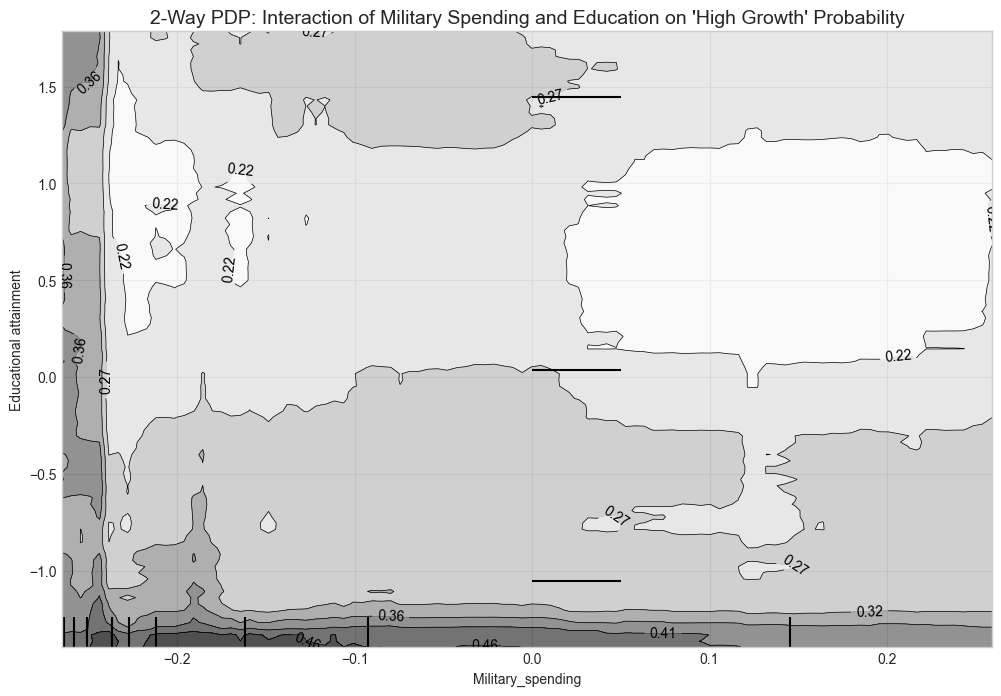

In [17]:
# 2-Way PDP for Military Spending and Educational Attainment 
fig2, ax2 = plt.subplots(figsize=(12, 8))
pdp_display_2way = PartialDependenceDisplay.from_estimator(
    estimator=final_rf_model,
    X=X_train_scaled,
    features=[('Military_spending', 'Educational attainment')],
    feature_names=feature_names.tolist(),
    target=2,
    ax=ax2
)
ax2.set_title("2-Way PDP: Interaction of Military Spending and Education on 'High Growth' Probability", fontsize=14)
plt.show()

Generating PDP for 'Merchandise trade' on 'High Growth'...


C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has fe

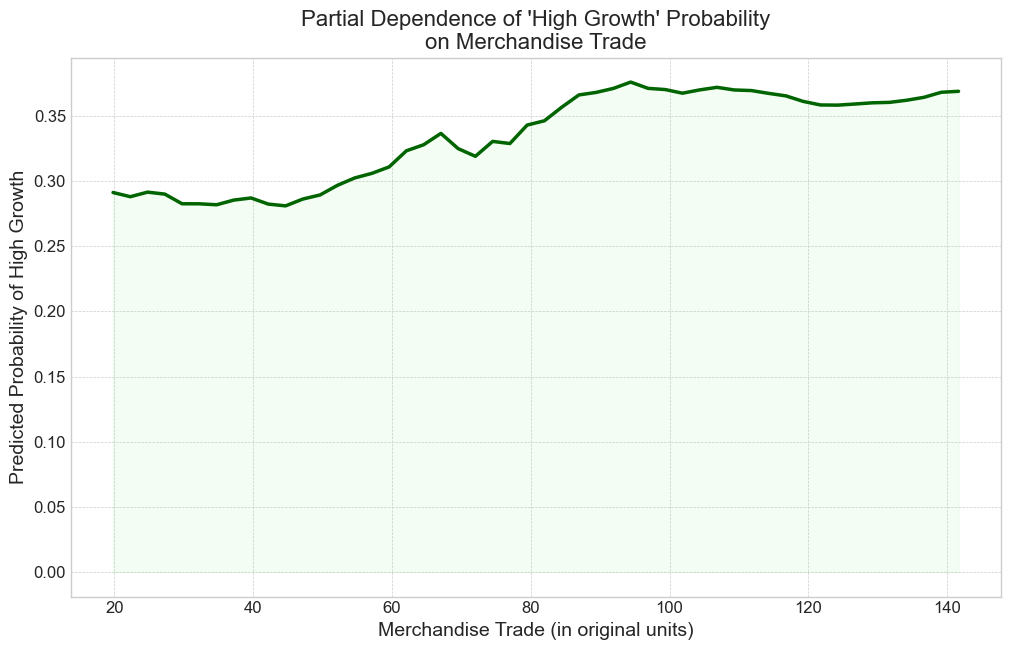

Generating PDP for 'Farright' on 'High Growth'...


C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


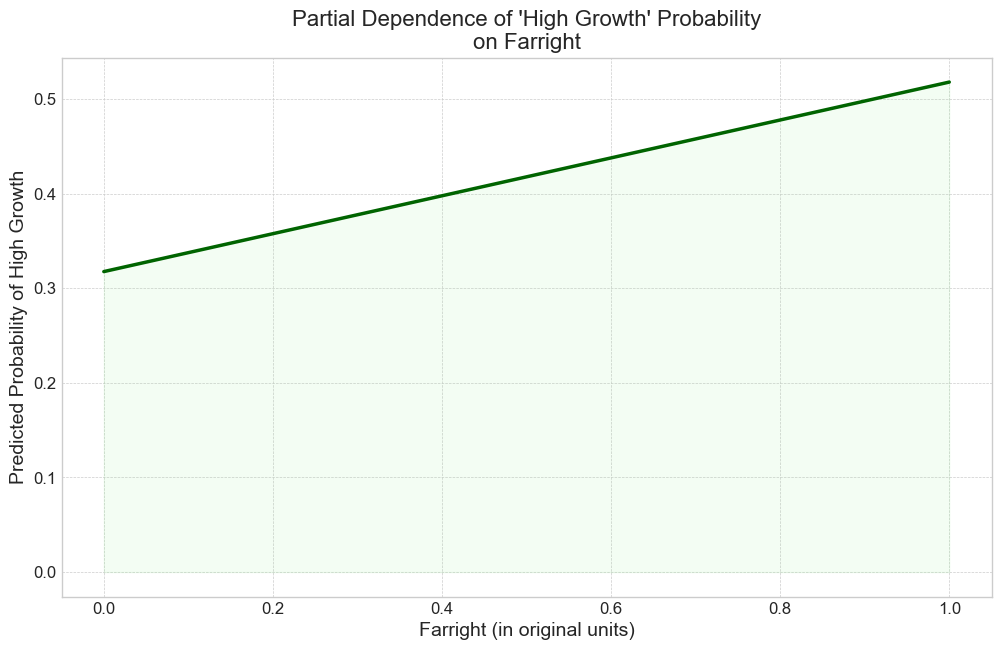

In [24]:
# ==============================================================================
# --- Helper Function for Reusable 1-Way PDP Plotting ---
# ==============================================================================

def plot_pdp(estimator, X_scaled_df, feature_name, target_class_index, target_class_name, scaler, original_X_df):
    """
    Calculates and plots a 1-way Partial Dependence Plot with an unscaled, interpretable x-axis.

    Args:
        estimator: The trained model (e.g., final_rf_model).
        X_scaled_df: The scaled feature data (as a DataFrame).
        feature_name: The name of the feature to plot (string).
        target_class_index: The index of the target class (e.g., 2 for 'High Growth').
        target_class_name: The display name of the target class (string).
        scaler: The fitted StandardScaler object.
        original_X_df: The original, unscaled feature DataFrame (for column indexing).
    """
    print(f"Generating PDP for '{feature_name}' on '{target_class_name}'...")

    # --- Calculation Step ---
    pdp_results = partial_dependence(
        estimator=estimator,
        X=X_scaled_df,
        features=[feature_name],
        response_method='predict_proba',
        grid_resolution=50
    )

    # --- Data Extraction and Transformation ---
    y_values = pdp_results['average'][target_class_index]
    scaled_x_values = pdp_results['grid_values'][0]

    dummy_array = np.zeros((len(scaled_x_values), X_scaled_df.shape[1]))
    feature_idx = original_X_df.columns.get_loc(feature_name)
    dummy_array[:, feature_idx] = scaled_x_values
    unscaled_x_values = scaler.inverse_transform(dummy_array)[:, feature_idx]

    # --- Plotting Step ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Use a different color based on the target class for clarity
    plot_color = 'darkgreen' if target_class_name == 'High Growth' else 'darkblue'
    fill_color = 'lightgreen' if target_class_name == 'High Growth' else 'lightblue'

    ax.plot(unscaled_x_values, y_values, color=plot_color, linewidth=2.5)
    ax.fill_between(unscaled_x_values, y_values, alpha=0.1, color=fill_color)

    # Clean up feature name for titles and labels
    clean_feature_name = feature_name.replace('_', ' ').title()

    ax.set_title(f"Partial Dependence of '{target_class_name}' Probability\non {clean_feature_name}", fontsize=16)
    ax.set_xlabel(f"{clean_feature_name} (in original units)", fontsize=14)
    ax.set_ylabel(f"Predicted Probability of {target_class_name}", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.show()


# ==============================================================================
# --- Generating the Specific Plots You Requested ---
# ==============================================================================

# Define target class constants for readability
HIGH_GROWTH_TARGET = 2
HIGH_GROWTH_NAME = 'High Growth'
MEDIUM_GROWTH_TARGET = 1
MEDIUM_GROWTH_NAME = 'Medium Growth'

# --- Plot 1: Capital Formation on HIGH GROWTH ---
plot_pdp(final_rf_model, X_train_scaled_df, 'Merchandise trade', HIGH_GROWTH_TARGET, HIGH_GROWTH_NAME, scaler, X_train)

# --- Plot 2: Population Growth on HIGH GROWTH ---
plot_pdp(final_rf_model, X_train_scaled_df, 'Population_growth', HIGH_GROWTH_TARGET, HIGH_GROWTH_NAME, scaler, X_train)



## Complementary Econometric Analysis

### Multinomial Logistic Regression:Reduced model

In [117]:
# Drop rows with any NaNs in reduced_model
red_model_df = reduced_model
# --- 2. Define Features (X) and Target (y) ---
# We use the entire dataset because this is for descriptive analysis, not predictive evaluation.
X_red = red_model_df.drop('GDP_growth_cat', axis=1)
y_red = red_model_df['GDP_growth_cat']

# --- 3. Scale the Features (Highly Recommended) ---
# Scaling ensures that the magnitudes of coefficients are comparable and helps the model converge properly.
# The interpretation becomes "for a one standard deviation increase in X..."
scaler = StandardScaler()
X_red_scaled = scaler.fit_transform(X_red)
# Convert back to a DataFrame to keep column names
X_red_scaled = pd.DataFrame(X_red_scaled, columns=X_red.columns, index=X_red.index)

# --- 4. Fit the Multinomial Logit Model with statsmodels ---

# Add a constant (intercept) to our scaled features. This is a crucial step.
X_red_const = sm.add_constant(X_red_scaled)

print("\nFitting Multinomial Logit model on the 'red_model' dataset...")
# Instantiate and fit the model
# The first category (0, i.e., 'Low Growth') will be the base category for comparison.
logit_model = sm.MNLogit(y_red, X_red_const)
result = logit_model.fit(method='newton') # Using 'newton' can help with convergence

# --- 5. Print the Detailed Summary ---
print("\n--- Statsmodels Multinomial Logit Summary ---")
print(result.summary())


Fitting Multinomial Logit model on the 'red_model' dataset...
Optimization terminated successfully.
         Current function value: 0.995948
         Iterations 7

--- Statsmodels Multinomial Logit Summary ---
                          MNLogit Regression Results                          
Dep. Variable:         GDP_growth_cat   No. Observations:                 1836
Model:                        MNLogit   Df Residuals:                     1818
Method:                           MLE   Df Model:                           16
Date:                Fri, 11 Jul 2025   Pseudo R-squ.:                 0.07809
Time:                        00:40:18   Log-Likelihood:                -1828.6
converged:                       True   LL-Null:                       -1983.4
Covariance Type:            nonrobust   LLR p-value:                 2.410e-56
      GDP_growth_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

C:\Users\tukhy\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:5475: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))


### Multinomial Logistic Regression:Full model

In [112]:
# For the max_model
max_model_df = pd.read_csv('max_model_final.csv')
# Drop rows with any NaNs in max_model
max_model_df = max_model_df.dropna()
max_model_df = max_model_df.drop(columns=['Moderateright', 'Farleft', 'Moderateleft'])
# --- 2. Define Features (X) and Target (y) ---
# We use the entire dataset because this is for descriptive analysis, not predictive evaluation.
X_max = max_model_df.drop('GDP_growth_cat', axis=1)
y_max = max_model_df['GDP_growth_cat']

# --- 3. Scale the Features (Highly Recommended) ---
# Scaling ensures that the magnitudes of coefficients are comparable and helps the model converge properly.
# The interpretation becomes "for a one standard deviation increase in X..."
scaler = StandardScaler()
X_max_scaled = scaler.fit_transform(X_max)
# Convert back to a DataFrame to keep column names
X_max_scaled = pd.DataFrame(X_max_scaled, columns=X_max.columns, index=X_max.index)

# --- 4. Fit the Multinomial Logit Model with statsmodels ---

# Add a constant (intercept) to our scaled features. This is a crucial step.
X_max_const = sm.add_constant(X_max_scaled)

print("\nFitting Multinomial Logit model on the 'max_model' dataset...")
# Instantiate and fit the model
# The first category (0, i.e., 'Low Growth') will be the base category for comparison.
logit_model = sm.MNLogit(y_max, X_max_const)
result = logit_model.fit(method='newton') # Using 'newton' can help with convergence

# --- 5. Print the Detailed Summary ---
print("\n--- Statsmodels Multinomial Logit Summary ---")
print(result.summary())


Fitting Multinomial Logit model on the 'max_model' dataset...
Optimization terminated successfully.
         Current function value: 0.934199
         Iterations 7

--- Statsmodels Multinomial Logit Summary ---
                          MNLogit Regression Results                          
Dep. Variable:         GDP_growth_cat   No. Observations:                  663
Model:                        MNLogit   Df Residuals:                      635
Method:                           MLE   Df Model:                           26
Date:                Fri, 11 Jul 2025   Pseudo R-squ.:                  0.1269
Time:                        00:23:13   Log-Likelihood:                -619.37
converged:                       True   LL-Null:                       -709.40
Covariance Type:            nonrobust   LLR p-value:                 5.449e-25
      GDP_growth_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------